In [6]:

import os
import pandas as pd
from google.colab import files

# --- 1️⃣ Recherche automatique dans /content
candidates = [f for f in os.listdir("/content") if f.lower().endswith((".dat", ".csv", ".txt"))]
if candidates:
    print("🔍 Fichiers trouvés dans /content :")
    for i, f in enumerate(candidates):
        print(f"  [{i}] {f}")
else:
    print("❌ Aucun fichier trouvé, tu peux téléverser un fichier maintenant.")

# --- 2️⃣ Téléversement manuel si nécessaire
if not candidates:
    uploaded = files.upload()
    candidates = list(uploaded.keys())

# --- 3️⃣ Sélection du fichier à utiliser
if candidates:
    fname = f"/content/{candidates[0]}"  # tu peux changer l’indice si plusieurs fichiers
    print(f"✅ Fichier sélectionné : {fname}")

    # --- 4️⃣ Lecture et aperçu automatique
    try:
        df = pd.read_csv(fname, sep=r"\s+", comment="#")
    except Exception:
        df = pd.read_csv(fname)
    print(f"Colonnes détectées : {list(df.columns)[:10]}")
    print(f"Nombres de lignes : {len(df)}")
else:
    print("⚠️ Aucun fichier à lire.")

❌ Aucun fichier trouvé, tu peux téléverser un fichier maintenant.


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES.dat
✅ Fichier sélectionné : /content/Pantheon+SH0ES.dat
Colonnes détectées : ['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG']
Nombres de lignes : 1701


In [ ]:

import numpy as np, pandas as pd
from scipy.integrate import cumulative_trapezoid
from itertools import product
import matplotlib.pyplot as plt

# ------------------------------
# 0) Chargement données
# ------------------------------
DATA_PATH = "/content/Pantheon+SH0ES.dat"   # adapte si besoin
OM_FIX    = 0.315
SIGMA_FLOOR = 0.08
np.seterr(all='ignore')

df = pd.read_csv(DATA_PATH, sep=r"\s+", comment="#", engine="python")
cols = df.columns.str.strip()
df.columns = cols

# On privilégie zCMB + MU_SH0ES (+ diag err) pour rester proche du Hubble diagram public
assert {"zCMB","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(set(df.columns)), \
    "Colonnes zCMB, MU_SH0ES, MU_SH0ES_ERR_DIAG introuvables."

z       = df["zCMB"].astype(float).to_numpy()
mu      = df["MU_SH0ES"].astype(float).to_numpy()
mu_err0 = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
mu_err0 = np.maximum(mu_err0, SIGMA_FLOOR)

# Nettoyage
mask = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err0) & (mu_err0>0)
z, mu, mu_err0 = z[mask], mu[mask], mu_err0[mask]
order = np.argsort(z)
z, mu, mu_err0 = z[order], mu[order], mu_err0[order]
N = len(z)
print(f"✓ Données : N={N} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err0.min():.3f},{mu_err0.max():.3f}]")

# ------------------------------
# 1) Modèles robustes (sans NaN/Inf)
# ------------------------------
def Ez_LCDM(z, Om):
    # E(z) >= 1e-12 pour éviter divisions par 0
    return np.sqrt(np.clip(Om*(1+z)**3 + (1-Om), 1e-12, None))

def mu_nom_LCDM(z, Om):
    # μ théorique SANS M (M marginalisé ensuite)
    integrand = 1.0 / Ez_LCDM(z, Om)
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.clip(I, 1e-30, None)
    return 5.0*np.log10(dl) + 25.0

def mu_nom_ELAS(z, Om, delta, Omega, phi):
    # modulation > 0 pour garder l'intégrale physique
    mod = 1.0 + delta*np.sin(Omega*np.log1p(z) + phi)
    mod = np.clip(mod, 1e-3, None)   # évite mod≤0
    integrand = 1.0 / (Ez_LCDM(z, Om) * mod)
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.clip(I, 1e-30, None)
    return 5.0*np.log10(dl) + 25.0

def chi2_min_over_M(mu_th, mu_obs, err):
    w = 1.0/(err*err)
    # M* = argmin χ² analytique :
    M_star = np.sum((mu_obs - mu_th)*w) / np.sum(w)
    r = (mu_obs - (mu_th + M_star)) / err
    return float(np.sum(r*r)), float(M_star), r

# ------------------------------
# 2) Renormalisation des erreurs @Ωm=0.315
# ------------------------------
muL = mu_nom_LCDM(z, OM_FIX)
chi2_base, M_base, r_base = chi2_min_over_M(muL, mu, mu_err0)
dof = N - 2  # (Om fixé, M marginalisé) ~ 1 param effectif, on reste conservateur avec 2
scale = np.sqrt(chi2_base / max(dof,1))
mu_err = mu_err0 * scale
chi2_base2, M_base2, r_base2 = chi2_min_over_M(muL, mu, mu_err)
chi2_red = chi2_base2 / max(dof,1)
print(f"[ΛCDM @Ωm={OM_FIX:.3f}] χ²={chi2_base2:.2f} | χ²_red≈{chi2_red:.2f} | M*={M_base2:.3f} | scale={scale:.3f}")

# ------------------------------
# 3) Scan ELAS (profil φ, δ pour chaque Ω)
# ------------------------------
O_grid   = np.linspace(1.5, 6.0, 19)             # élargi
phi_grid = np.linspace(-np.pi, np.pi, 145)       # fin
d_grid   = np.concatenate([np.linspace(0.0, 0.25, 51), np.linspace(0.26, 0.60, 35)])

best_overall = {"chi2": np.inf, "Omega": None, "phi": None, "delta": None, "M": None}
for O in O_grid:
    best_O = {"chi2": np.inf}
    for phi in phi_grid:
        # petite recherche 1D sur d (grille) — robuste et suffisant pour borne δ_95
        for d in d_grid:
            muE = mu_nom_ELAS(z, OM_FIX, d, O, phi)
            chi2E, M_E, _ = chi2_min_over_M(muE, mu, mu_err)
            if chi2E < best_O.get("chi2", np.inf):
                best_O.update({"chi2": chi2E, "Omega": O, "phi": phi, "delta": d, "M": M_E})
    if best_O["chi2"] < best_overall["chi2"]:
        best_overall = dict(best_O)

chi2_ELAS = best_overall["chi2"]
d_best, O_best, phi_best, M_best = best_overall["delta"], best_overall["Omega"], best_overall["phi"], best_overall["M"]
dchi2_obs = chi2_base2 - chi2_ELAS
print(f"[ELAS profilé] Ω*={O_best:.2f} | δ*={d_best:.3f} | φ*={phi_best:.2f} | χ²_ELAS={chi2_ELAS:.2f}")
print(f"[OBS] Δχ²_obs = {dchi2_obs:.2f}  (ELAS vs ΛCDM @ Ωm={OM_FIX:.3f})")

# ------------------------------
# 4) Profil de vraisemblance en δ (borne δ_95%) à Ω=Ω*, φ profilé
# ------------------------------
d_prof = np.linspace(0.0, 0.60, 241)
chi_prof = np.full_like(d_prof, np.inf, dtype=float)
for i, dval in enumerate(d_prof):
    chi_min_phi = np.inf
    for phi in phi_grid:
        muE = mu_nom_ELAS(z, OM_FIX, dval, O_best, phi)
        chi2E, _, _ = chi2_min_over_M(muE, mu, mu_err)
        if chi2E < chi_min_phi:
            chi_min_phi = chi2E
    chi_prof[i] = chi_min_phi

chi_min = chi_prof.min()
mask95 = (chi_prof - chi_min) <= 3.84   # 95% pour 1 param
d95 = d_prof[mask95].max() if np.any(mask95) else np.nan
print(f"[Profil δ @ Ω*={O_best:.2f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

# ------------------------------
# 5) Look-Elsewhere Effect (permute les résidus normalisés)
# ------------------------------
rng = np.random.default_rng(12345)
Nperm = 500   # mets 1000–2000 si tu veux raffiner
dchi2_perm = np.zeros(Nperm, dtype=float)

mu_th_base = muL + M_base2
r0 = (mu - mu_th_base)/mu_err

for k in range(Nperm):
    r_perm = rng.permutation(r0)
    mu_perm = mu_th_base + mu_err * r_perm

    chi2_best_perm = np.inf
    for O in O_grid[::2]:
        for phi in phi_grid[::3]:
            # profil d sur la grille grossière
            for d in d_grid[::2]:
                muE = mu_nom_ELAS(z, OM_FIX, d, O, phi)
                chi2E, _, _ = chi2_min_over_M(muE, mu_perm, mu_err)
                if chi2E < chi2_best_perm:
                    chi2_best_perm = chi2E
    dchi2_perm[k] = chi2_base2 - chi2_best_perm
    if (k+1) % 50 == 0:
        print(f"perm {k+1}/{Nperm} ... Δχ²_max^perm ~ {dchi2_perm[k]:.2f}")

pval = (np.sum(dchi2_perm >= dchi2_obs) + 1.0) / (Nperm + 1.0)
print("\n=== RÉSUMÉ FINAL ===")
print(f"Ωm fixé = {OM_FIX:.3f}")
print(f"χ²_LCDM (renorm) = {chi2_base2:.2f}")
print(f"ELAS: Ω*={O_best:.2f}, δ*={d_best:.3f}, φ*={phi_best:.2f}, χ²_ELAS={chi2_ELAS:.2f}")
print(f"Δχ²_obs = {dchi2_obs:.2f}")
print(f"δ_95% ≲ {d95:.3f}")
print(f"p-value (LEE, Nperm={Nperm}) ≈ {pval:.4f}")

# (optionnel) histogramme LEE
plt.figure(figsize=(6,4))
plt.hist(dchi2_perm, bins=40, alpha=0.75, label="Δχ² permuté")
plt.axvline(dchi2_obs, color="r", ls="--", label="Δχ² observé")
plt.xlabel("Δχ² (ELAS - ΛCDM)")
plt.ylabel("Comptes")
plt.legend()
plt.title(f"LEE • p≈{pval:.4f}")
plt.tight_layout()
plt.show()

✓ Données : N=1701 | z∈[0.0012,2.2613] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM @Ωm=0.315] χ²=1699.00 | χ²_red≈1.00 | M*=18.118 | scale=3.186
[ELAS profilé] Ω*=2.50 | δ*=0.600 | φ*=0.79 | χ²_ELAS=1660.22
[OBS] Δχ²_obs = 38.78  (ELAS vs ΛCDM @ Ωm=0.315)
[Profil δ @ Ω*=2.50] χ²_min=1660.22 | δ_95% ≲ 0.600
perm 50/500 ... Δχ²_max^perm ~ 6.13
perm 100/500 ... Δχ²_max^perm ~ 5.95
perm 150/500 ... Δχ²_max^perm ~ 8.36
perm 200/500 ... Δχ²_max^perm ~ 6.21
perm 250/500 ... Δχ²_max^perm ~ 11.52
perm 300/500 ... Δχ²_max^perm ~ 4.49
perm 350/500 ... Δχ²_max^perm ~ 4.11
perm 400/500 ... Δχ²_max^perm ~ 8.97
perm 450/500 ... Δχ²_max^perm ~ 5.72


In [ ]:

# --- Imports
import numpy as np, pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from numpy.random import default_rng

# --- Charger Pantheon+SH0ES : uploade d'abord le fichier dans Colab (barre à gauche)
# Fichier typique: "Pantheon+SH0ES.dat" (colonnes MU_SH0ES, MU_SH0ES_ERR_DIAG, zHD)
df = pd.read_csv("/content/Pantheon+SH0ES.dat", sep=r"\s+", comment="#")
z = df["zHD"].astype(float).to_numpy()
mu = df["MU_SH0ES"].astype(float).to_numpy()
mu_err = np.maximum(df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy(), 0.08)  # plancher d’erreur réaliste

# --- Outils
c = 299792.458  # km/s

def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(Om*(1+z)**3 + Ol)

def mu_LCDM(z, Om, M):
    # d_L = (c/H0) (1+z) ∫dz'/E(z'); H0 absorbé dans M (marginalisation)
    Ez = Ez_LCDM(z, Om)
    I = cumulative_trapezoid(1.0/Ez, z, initial=0.0)
    dl = (1+z) * I  # H0 factor absorbé dans M
    dl = np.maximum(dl, 1e-12)  # sécurité
    return 5*np.log10(dl) + 25 + M

def mu_ELAS(z, Om, delta, Omega, phi, M):
    # Modulation multiplicative de l’intégrande : (1 + δ sin(Ω ln(1+z)+φ))
    Ez = Ez_LCDM(z, Om)
    arg = Omega*np.log(1.0 + z) + phi
    mod = 1.0 + delta*np.sin(arg)
    I = cumulative_trapezoid(mod/Ez, z, initial=0.0)
    dl = (1+z) * I
    dl = np.maximum(dl, 1e-12)
    return 5*np.log10(dl) + 25 + M

def chi2(y_model, y, yerr):
    r = (y - y_model)/yerr
    return float(np.sum(r*r))

def fit_L(T, y, yerr):
    # Ajuste Om, M (LCDM)
    p0 = [0.30, 0.0]
    popt,_ = curve_fit(lambda z, Om, M: mu_LCDM(z, Om, M), T, y, p0=p0, sigma=yerr, absolute_sigma=True, maxfev=20000)
    Om, M = popt
    chi = chi2(mu_LCDM(T, Om, M), y, yerr)
    return dict(Om=Om, M=M, chi2=chi)

def fit_E(T, y, yerr, Om_init=0.30, d0=0.02, O0=5.0, p0=-2.0, M0=0.0, bounds=([0.05, 0.0, 2.0, -np.pi, -5.0],[0.6, 0.5, 12.0, np.pi, 5.0])):
    # Ajuste Om, δ, Ω, φ, M (élastique)
    p0 = [Om_init, d0, O0, p0, M0]
    popt,_ = curve_fit(lambda z, Om, d, O, p, M: mu_ELAS(z, Om, d, O, p, M), T, y, p0=p0,
                       sigma=yerr, absolute_sigma=True, bounds=bounds, maxfev=30000)
    Om, d, O, p, M = popt
    chi = chi2(mu_ELAS(T, Om, d, O, p, M), y, yerr)
    return dict(Om=Om, delta=d, Omega=O, phi=p, M=M, chi2=chi)

In [ ]:

# --- Fit de base
L = fit_L(z, mu, mu_err)
E = fit_E(z, mu, mu_err, Om_init=L["Om"])

print(f"[LCDM]  Om={L['Om']:.3f} | chi2={L['chi2']:.2f}")
print(f"[ELAS]  Om={E['Om']:.3f} δ={E['delta']:.3f} Ω={E['Omega']:.2f} φ={E['phi']:.2f} | chi2={E['chi2']:.2f}")
print(f"Δχ²(ELAS-LCDM) = {L['chi2'] - E['chi2']:.2f}  (ddl=2 si Ω fixé; 4 si libre)")

# --- Robustesse Ωm : fixé au consensus Planck 0.315
def fit_L_fixOm(Om_fix):
    # marginalise seulement M
    p0 = [0.0]
    popt,_ = curve_fit(lambda z, M: mu_LCDM(z, Om_fix, M), z, mu, p0=p0, sigma=mu_err, absolute_sigma=True)
    M = popt[0]
    return dict(Om=Om_fix, M=M, chi2=chi2(mu_LCDM(z, Om_fix, M), mu, mu_err))

def fit_E_fixOm(Om_fix, O_fix=None):
    # si O_fix est fixé, ddl=2 (δ, φ) + M
    if O_fix is None:
        popt,_ = curve_fit(lambda z, d, O, p, M: mu_ELAS(z, Om_fix, d, O, p, M),
                           z, mu, p0=[0.02, 5.0, -2.0, 0.0], sigma=mu_err, absolute_sigma=True, maxfev=30000)
        d,O,p,M = popt
    else:
        popt,_ = curve_fit(lambda z, d, p, M: mu_ELAS(z, Om_fix, d, O_fix, p, M),
                           z, mu, p0=[0.02, -2.0, 0.0], sigma=mu_err, absolute_sigma=True, maxfev=30000)
        d,p,M = popt; O = O_fix
    chi = chi2(mu_ELAS(z, Om_fix, d, O, p, M), mu, mu_err)
    return dict(Om=Om_fix, delta=d, Omega=O, phi=p, M=M, chi2=chi)

Lfix = fit_L_fixOm(0.315)
Efix = fit_E_fixOm(0.315, O_fix=None)  # laisse Ω libre; tu peux aussi fixer Ω=~5 si tu veux ddl=2
print(f"[Ωm fixé=0.315] LCDM chi2={Lfix['chi2']:.2f} | ELAS chi2={Efix['chi2']:.2f} | Δχ²={Lfix['chi2']-Efix['chi2']:.2f}")

# --- Profil de vraisemblance en δ (contrainte δ_95%)
def delta_profile(Om_fix=0.315, O_fix=None, deltas=np.linspace(0.0, 0.20, 41)):
    prof = []
    for d in deltas:
        # minimiser sur (φ, M) (et Ω si O_fix=None)
        if O_fix is None:
            p0=[5.0, -2.0, 0.0]
            popt,_ = curve_fit(lambda z, O, p, M: mu_ELAS(z, Om_fix, d, O, p, M),
                               z, mu, p0=p0, sigma=mu_err, absolute_sigma=True, maxfev=20000)
            O,p,M = popt
        else:
            p0=[-2.0, 0.0]
            popt,_ = curve_fit(lambda z, p, M: mu_ELAS(z, Om_fix, d, O_fix, p, M),
                               z, mu, p0=p0, sigma=mu_err, absolute_sigma=True, maxfev=20000)
            O=O_fix; p,M = popt
        chi = chi2(mu_ELAS(z, Om_fix, d, O, p, M), mu, mu_err)
        prof.append((d, chi, O, p, M))
    prof = np.array(prof, dtype=object)
    chi_min = float(np.min(prof[:,1]))
    # borne sup 95% : Δχ²=3.84 (1 param)
    mask95 = (prof[:,1].astype(float) - chi_min <= 3.84)
    d95 = float(np.max(prof[mask95,0])) if np.any(mask95) else np.nan
    return prof, d95, chi_min

prof, d95, chi_min = delta_profile(Om_fix=0.315, O_fix=None)
print(f"[Profil δ | Ωm=0.315]  δ_95%  ≲ {d95:.3f}  (Δχ²=3.84)")

/tmp/ipython-input-2685237796.py:19: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Om*(1+z)**3 + Ol)
/tmp/ipython-input-3411276291.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,_ = curve_fit(lambda z, O, p, M: mu_ELAS(z, Om_fix, d, O, p, M),


[LCDM]  Om=0.538 | chi2=2769.02
[ELAS]  Om=0.050 δ=0.000 Ω=12.00 φ=-3.14 | chi2=6598098.73
Δχ²(ELAS-LCDM) = -6595329.70  (ddl=2 si Ω fixé; 4 si libre)
[Ωm fixé=0.315] LCDM chi2=2883.47 | ELAS chi2=2668.05 | Δχ²=215.42
[Profil δ | Ωm=0.315]  δ_95%  ≲ 0.095  (Δχ²=3.84)


In [ ]:

rng = default_rng(123)

# --- Scan (Ω, φ) pour le signal observé
def scan_Ophi(Om_fix=0.315, d_fix=None, O_grid=np.linspace(2.0,10.0,33), phi_grid=np.linspace(-np.pi, np.pi, 49)):
    best = {"dchi":-np.inf, "O":None, "phi":None, "delta":None, "chiE":None}
    # Option 1: δ libre aussi (ddl=2 si O fixé; 3 si O libre et φ libre) -> plus sévère
    for O in O_grid:
        for p in phi_grid:
            # fit δ, M à O,φ fixés
            popt,_ = curve_fit(lambda z, d, M: mu_ELAS(z, Om_fix, d, O, p, M),
                               z, mu, p0=[0.02, 0.0], sigma=mu_err, absolute_sigma=True, maxfev=15000,
                               bounds=([0.0, -5.0],[0.5, 5.0]))
            d, M = popt
            chiE = chi2(mu_ELAS(z, Om_fix, d, O, p, M), mu, mu_err)
            # LCDM de référence (M ré-ajusté)
            poptL,_ = curve_fit(lambda z, M: mu_LCDM(z, Om_fix, M), z, mu, p0=[0.0], sigma=mu_err, absolute_sigma=True)
            ML = poptL[0]
            chiL = chi2(mu_LCDM(z, Om_fix, ML), mu, mu_err)
            dchi = chiL - chiE
            if dchi > best["dchi"]:
                best.update({"dchi":dchi, "O":O, "phi":p, "delta":d, "chiE":chiE})
    return best

best_obs = scan_Ophi(Om_fix=0.315)
print(f"[Scan observé] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['O']:.2f}, φ={best_obs['phi']:.2f}, δ~{best_obs['delta']:.3f}")

# --- Test de permutation (look-elsewhere effect)
def perm_test(nperm=1000, Om_fix=0.315):
    # on permute les résidus sous LCDM et on rescanne
    poptL,_ = curve_fit(lambda z, M: mu_LCDM(z, Om_fix, M), z, mu, p0=[0.0], sigma=mu_err, absolute_sigma=True)
    ML = poptL[0]
    muL = mu_LCDM(z, Om_fix, ML)
    res = (mu - muL)  # résidus observés
    dchi_max = []
    for k in range(nperm):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        # rescan (réutilise mu_fake)
        best = {"dchi":-np.inf}
        O_grid=np.linspace(2.0,10.0,33); phi_grid=np.linspace(-np.pi,np.pi,49)
        for O in O_grid:
            for p in phi_grid:
                popt,_ = curve_fit(lambda z, d, M: mu_ELAS(z, Om_fix, d, O, p, M),
                                   z, mu_fake, p0=[0.02, 0.0], sigma=mu_err, absolute_sigma=True, maxfev=12000,
                                   bounds=([0.0, -5.0],[0.5, 5.0]))
                d, M = popt
                chiE = chi2(mu_ELAS(z, Om_fix, d, O, p, M), mu_fake, mu_err)
                chiL = chi2(muL, mu_fake, mu_err)  # même LCDM (muL)
                dchi = chiL - chiE
                if dchi > best["dchi"]:
                    best["dchi"] = dchi
        dchi_max.append(best["dchi"])
    dchi_max = np.array(dchi_max)
    pval = np.mean(dchi_max >= best_obs["dchi"])
    return float(pval), dchi_max

p_lee, dist = perm_test(nperm=500, Om_fix=0.315)
print(f"[Permutation LEE] p ≈ {p_lee:.4f}  (corrigé pour le scan Ω,φ)")

# --- Cross-Validation (k-fold = 5)
def kfold_cv(k=5, Om_fix=0.315, O_fix=None):
    N = len(z)
    idx = np.arange(N)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    gains = []
    for i in range(k):
        test = folds[i]
        train = np.setdiff1d(idx, test)
        # fit sur train
        poptL,_ = curve_fit(lambda z, M: mu_LCDM(z, Om_fix, M), z[train], mu[train], p0=[0.0],
                            sigma=mu_err[train], absolute_sigma=True)
        ML = poptL[0]
        chiL_test = chi2(mu_LCDM(z[test], Om_fix, ML), mu[test], mu_err[test])

        poptE,_ = curve_fit(lambda z, d, O, p, M: mu_ELAS(z, Om_fix, d, O, p, M),
                            z[train], mu[train], p0=[0.02, 5.0, -2.0, 0.0],
                            sigma=mu_err[train], absolute_sigma=True, maxfev=25000)
        d,O,p,M = poptE
        chiE_test = chi2(mu_ELAS(z[test], Om_fix, d, O, p, M), mu[test], mu_err[test])
        gains.append(chiL_test - chiE_test)
    return np.array(gains)

gains = kfold_cv(k=5, Om_fix=0.315)
print(f"[CV 5-fold] Δχ² (test) moyen = {gains.mean():.2f} ± {gains.std():.2f}")

[Scan observé] Δχ²_max=-5841847.94 @ Ω=2.00, φ=1.44, δ~0.500


KeyboardInterrupt: 

In [ ]:

# ============================================================
#  TOUT-EN-UN : Test modèle élastique vs ΛCDM sur Pantheon+SH0ES
#  - Chargement auto du fichier (ou upload)
#  - Tri par z, sécurités numériques
#  - Marginalisation analytique de M (ΛCDM & ELAS)
#  - Fit robuste ΛCDM (balayage Ωm)
#  - Scan ELAS @ Ωm=0.315 (Ω,φ) + profil δ -> δ_95%
#  - Test de permutation (look-elsewhere) sur (Ω,φ,δ)
#  - (Optionnel) Cross-validation k-fold
#  - Résumé final imprimé
# ============================================================

import os, re, numpy as np, pandas as pd
from numpy.random import default_rng
from scipy.integrate import cumulative_trapezoid

# -----------------------
# Réglages utilisateur
# -----------------------
ERR_FLOOR = 0.08                 # plancher d'erreur (mag)
OM_SCAN   = (0.20, 0.40, 401)    # Ωm grid pour ΛCDM robuste (min, max, N)
OM_FIX    = 0.315                # Ωm fixé pour ELAS (consensus Planck)
O_GRID    = np.linspace(2.0, 10.0, 33)           # Ω (fréquence) pour scan ELAS
PHI_GRID  = np.linspace(-np.pi, np.pi, 49)       # φ (phase) pour scan ELAS
DELTA_GRID= np.linspace(0.00, 0.20, 41)          # δ ∈ [0,0.2]
N_PERM    = 400                  # permutations LEE (augmenter pour +précision)
DO_CV     = False                # activer cross-validation k-fold ?
K_FOLD    = 5                    # nb folds CV
RNG_SEED  = 12345                # seed RNG pour reproductibilité

rng = default_rng(RNG_SEED)

# -----------------------
# 1) Chargement du fichier
# -----------------------
def load_sn_data():
    # Cherche un fichier déjà présent
    candidates = [f for f in os.listdir("/content")
                  if re.search(r"(?i)(pantheon\+?shoes|pantheon\+|sn).*\.((dat)|(txt)|(csv))$", f)]
    fname = None
    if candidates:
        # On prend le plus récent (au cas où)
        candidates.sort(key=lambda x: os.path.getmtime(os.path.join("/content", x)), reverse=True)
        fname = os.path.join("/content", candidates[0])
    else:
        # Fenêtre d'upload
        try:
            from google.colab import files
            print("➡️  Aucune donnée détectée. Téléverse un fichier (Pantheon+SH0ES.dat ou z,mu,sigma_mu).")
            up = files.upload()
            if up:
                fname = list(up.keys())[0]
                fname = "/content/" + fname
        except Exception as e:
            raise RuntimeError("Aucun fichier trouvé et upload non disponible. Place un fichier dans /content et relance.") from e

    # Lecture
    try:
        df = pd.read_csv(fname, sep=r"\s+", comment="#")
    except Exception:
        df = pd.read_csv(fname)

    # Détection des colonnes
    if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
        origin = "Pantheon+SH0ES"
    elif {"z","mu","sigma_mu"}.issubset(df.columns):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
        origin = "Generic(z,mu,sigma_mu)"
    else:
        raise RuntimeError("Colonnes non reconnues. Attendu (zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG) ou (z,mu,sigma_mu).")

    # Nettoyage + tri par z
    mu_err = np.maximum(mu_err, ERR_FLOOR)
    ok = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err > 0)
    z, mu, mu_err = z[ok], mu[ok], mu_err[ok]
    ord_idx = np.argsort(z)
    z, mu, mu_err = z[ord_idx], mu[ord_idx], mu_err[ord_idx]

    print(f"✓ Données: {origin} | N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] "
          f"| μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")
    return z, mu, mu_err, origin

z, mu, mu_err, origin = load_sn_data()

# -----------------------
# 2) Modèles + M marginalisé analytiquement
# -----------------------
def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0  # SANS M

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0 / Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)  # δ<=0.5 ⇒ mod>=0.5 => intégrande positive
    return mu_model_from_integrand(z, mod / Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    # minimise χ²(mu_nom + M) analytiquement en M
    w = 1.0 / (err*err)
    M_star = np.sum((mu_obs - mu_nom)*w) / np.sum(w)
    r = (mu_obs - (mu_nom + M_star)) / err
    return float(np.sum(r*r)), float(M_star)

# -----------------------
# 3) ΛCDM robuste (balayage fin en Ωm)
# -----------------------
Om_min, Om_max, Om_N = OM_SCAN
Om_grid = np.linspace(Om_min, Om_max, Om_N)
chiL_list = []
for Om in Om_grid:
    mu_nom = mu_LCDM_nom(z, Om)
    chi, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
    chiL_list.append((Om, chi, Mstar))
chiL = np.array(chiL_list, dtype=float)
j = np.argmin(chiL[:,1])
Om_best, chi2_LCDM_best, M_LCDM_best = chiL[j]
print(f"[ΛCDM robuste] Ωm_best={Om_best:.3f} | χ²={chi2_LCDM_best:.2f} | M*={M_LCDM_best:.3f}")

# -----------------------
# 4) ELAS @ Ωm fixé (0.315) : scan (Ω,φ) + profil δ
# -----------------------
def scan_elastic(Om_fix, O_grid, phi_grid, d_grid):
    # Δχ²_max = max_{Ω,φ} [ χ²_LCDM(Om_fix) - min_{δ}(χ²_ELAS) ]
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)

    best = {"dchi": -np.inf}
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            d_best = None; M_best = None
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
                    d_best = d; M_best = Mstar
            dchi = chiL_fix - chi_min_loc
            if dchi > best["dchi"]:
                best.update({"dchi": dchi, "Omega": O, "phi": p,
                             "delta": d_best, "chiE": chi_min_loc,
                             "chiL_fix": chiL_fix, "M_L_fix": ML_fix, "M_E": M_best})
    return best

best_obs = scan_elastic(OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f}")

# Profil δ au point (Ω,φ) meilleur
def delta_profile(Om_fix, O_fix, p_fix, d_grid):
    prof=[]
    for d in d_grid:
        mu_nom = mu_ELAS_nom(z, Om_fix, d, O_fix, p_fix)
        chiE, _ = chi2_min_over_M(mu_nom, mu, mu_err)
        prof.append((d, chiE))
    prof = np.array(prof, dtype=float)
    chi_min = np.min(prof[:,1])
    mask95 = (prof[:,1] - chi_min) <= 3.84  # 95% pour 1 param
    d95 = np.max(prof[mask95,0]) if np.any(mask95) else np.nan
    return prof, chi_min, d95

prof, chi_min, d95 = delta_profile(OM_FIX, best_obs["Omega"], best_obs["phi"], DELTA_GRID)
print(f"[Profil δ | Ωm={OM_FIX:.3f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

# -----------------------
# 5) Look-Elsewhere Effect (permutations des résidus)
# -----------------------
def perm_test_lee(nperm, Om_fix, O_grid, phi_grid, d_grid, rng):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    muL = muL_nom + ML_fix
    res = mu - muL
    observed = best_obs["dchi"]

    dchi_max = []
    for k in range(nperm):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        # rescan (sur mu_fake)
        muL_nom = mu_LCDM_nom(z, Om_fix)
        chiL, ML = chi2_min_over_M(muL_nom, mu_fake, mu_err)
        best_local = -np.inf
        for O in O_grid:
            for p in phi_grid:
                chi_min_loc = np.inf
                for d in d_grid:
                    mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                    chiE, _ = chi2_min_over_M(mu_nom, mu_fake, mu_err)
                    if chiE < chi_min_loc:
                        chi_min_loc = chiE
                dchi = chiL - chi_min_loc
                if dchi > best_local:
                    best_local = dchi
        dchi_max.append(best_local)
        if (k+1) % max(1, nperm//10) == 0:
            print(f"  perm {k+1}/{nperm} ... Δχ²_max^perm ~ {best_local:.2f}")
    dchi_max = np.array(dchi_max, dtype=float)
    pval = float(np.mean(dchi_max >= observed))
    return pval, dchi_max

print(f"[LEE] permutations en cours (n={N_PERM}) ...")
p_lee, dperm = perm_test_lee(N_PERM, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID, rng)
print(f"[LEE] p ≈ {p_lee:.4f}  (corrigé pour scan (Ω,φ,δ))")

# -----------------------
# 6) (Optionnel) Cross-Validation k-fold
# -----------------------
def kfold_cv(k=5, Om_fix=OM_FIX, O_grid=O_GRID, phi_grid=PHI_GRID, d_grid=DELTA_GRID, rng=rng):
    N = len(z)
    idx = np.arange(N)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    gains = []
    for i in range(k):
        test = folds[i]
        train = np.setdiff1d(idx, test)

        # LCDM sur train
        chiL_list = []
        for Om in Om_grid:
            mu_nom = mu_LCDM_nom(z[train], Om)
            chi, ML = chi2_min_over_M(mu_nom, mu[train], mu_err[train])
            chiL_list.append((Om, chi))
        chiL_arr = np.array(chiL_list, dtype=float)
        j = np.argmin(chiL_arr[:,1])
        Om_star = chiL_arr[j,0]

        # Eval test
        mu_nom_full = mu_LCDM_nom(z[test], Om_star)
        chiL_test, _ = chi2_min_over_M(mu_nom_full, mu[test], mu_err[test])

        # ELAS @Om_fix (scan + profil δ) sur train, puis évalue sur test
        best_tr = {"dchi": -np.inf}
        muL_nom_train = mu_LCDM_nom(z[train], Om_fix)
        chiL_fix_tr, ML_fix_tr = chi2_min_over_M(muL_nom_train, mu[train], mu_err[train])

        for O in O_grid:
            for p in phi_grid:
                chi_min_loc = np.inf
                d_best = None
                for d in d_grid:
                    mu_nom_tr = mu_ELAS_nom(z[train], Om_fix, d, O, p)
                    chiE_tr, _ = chi2_min_over_M(mu_nom_tr, mu[train], mu_err[train])
                    if chiE_tr < chi_min_loc:
                        chi_min_loc = chiE_tr; d_best = d
                dchi_tr = chiL_fix_tr - chi_min_loc
                if dchi_tr > best_tr["dchi"]:
                    best_tr.update({"dchi": dchi_tr, "Omega": O, "phi": p, "delta": d_best})

        # Eval sur test avec (O,φ,δ) trouvés sur train
        mu_nom_E_test = mu_ELAS_nom(z[test], Om_fix, best_tr["delta"], best_tr["Omega"], best_tr["phi"])
        chiE_test, _ = chi2_min_over_M(mu_nom_E_test, mu[test], mu_err[test])
        gains.append(chiL_test - chiE_test)
        print(f"  [fold {i+1}/{k}] Δχ²_test = {gains[-1]:.2f}")
    return np.array(gains, dtype=float)

if DO_CV:
    print("[CV] Cross-validation en cours ...")
    gains = kfold_cv(K_FOLD, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID, rng)
    print(f"[CV] Δχ²_test moyen = {gains.mean():.2f} ± {gains.std():.2f}")
else:
    gains = None

# -----------------------
# 7) Résumé final — à copier dans l’article
# -----------------------
print("\n==================== RÉSUMÉ FINAL ====================")
print(f"Données : {origin} | N = {len(z)} | floor σμ = {ERR_FLOOR:.2f} mag")
print(f"[ΛCDM robuste] Ωm_best = {Om_best:.3f} | χ² = {chi2_LCDM_best:.2f}")
print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max = {best_obs['dchi']:.2f}  "
      f"@ (Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f})")
print(f"[Profil δ] δ_95%  ≲ {d95:.3f}  (Δχ²=3.84, 1 param)")
print(f"[Look-Elsewhere] p ≈ {p_lee:.4f}  (n_perm={N_PERM})")
if gains is not None:
    print(f"[Cross-Validation] Δχ²_test moyen = {gains.mean():.2f} ± {gains.std():.2f} (k={K_FOLD})")
print("======================================================")

✓ Données: Pantheon+SH0ES | N=1701 | z∈[0.0012,2.2614] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM robuste] Ωm_best=0.400 | χ²=17027.65 | M*=18.136
[ELAS @Ωm=0.315] Δχ²_max=225.24 @ Ω=3.25, φ=-2.49, δ≈0.200
[Profil δ | Ωm=0.315] χ²_min=16881.18 | δ_95% ≲ 0.200
[LEE] permutations en cours (n=400) ...


KeyboardInterrupt: 

In [ ]:

# ============================================================
#  REPRISE "CHECKPOINT" — Look-Elsewhere permutations (LEE)
#  - Recharge ton état précédent si /content/elas_checkpoint.npz existe
#  - Sinon, reconstruit les résultats (LCDM & ELAS) une fois
#  - Reprend le test de permutations à partir du dernier index
#  - Imprime le résumé final
# ============================================================

import os, re, numpy as np, pandas as pd
from numpy.random import default_rng
from scipy.integrate import cumulative_trapezoid

# -----------------------
# Réglages (tu peux ajuster)
# -----------------------
CHECKPOINT = "/content/elas_checkpoint.npz"
ERR_FLOOR  = 0.08
OM_SCAN    = (0.20, 0.40, 401)
OM_FIX     = 0.315                        # Ωm fixé pour ELAS
O_GRID     = np.linspace(2.0, 10.0, 33)   # Ω pour scan
PHI_GRID   = np.linspace(-np.pi, np.pi, 49)
DELTA_GRID = np.linspace(0.00, 0.20, 41)  # δ ∈ [0, 0.2]
TARGET_PERM= 400                           # nombre de permutations visées
RNG_SEED   = 12345
rng        = default_rng(RNG_SEED)

# -----------------------
# Outils
# -----------------------
def load_sn_data():
    # Essaie un fichier Pantheon+SH0ES récent ou demande upload
    candidates = [f for f in os.listdir("/content")
                  if re.search(r"(?i)(pantheon\+?shoes|pantheon\+|sn).*\.((dat)|(txt)|(csv))$", f)]
    fname = None
    if candidates:
        candidates.sort(key=lambda x: os.path.getmtime(os.path.join("/content", x)), reverse=True)
        fname = os.path.join("/content", candidates[0])
    else:
        try:
            from google.colab import files
            print("➡️  Téléverse un fichier (Pantheon+SH0ES.dat ou z,mu,sigma_mu).")
            up = files.upload()
            if up:
                fname = list(up.keys())[0]
                fname = "/content/" + fname
        except Exception as e:
            raise RuntimeError("Aucun fichier trouvé et upload indisponible. Place un fichier dans /content.") from e

    try:
        df = pd.read_csv(fname, sep=r"\s+", comment="#")
    except Exception:
        df = pd.read_csv(fname)

    if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
        origin = "Pantheon+SH0ES"
    elif {"z","mu","sigma_mu"}.issubset(df.columns):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
        origin = "Generic(z,mu,sigma_mu)"
    else:
        raise RuntimeError("Colonnes non reconnues. Attendu (zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG) OU (z,mu,sigma_mu).")

    mu_err = np.maximum(mu_err, ERR_FLOOR)
    ok = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err > 0)
    z, mu, mu_err = z[ok], mu[ok], mu_err[ok]
    ord_idx = np.argsort(z)
    z, mu, mu_err = z[ord_idx], mu[ord_idx], mu_err[ord_idx]
    print(f"✓ Données: {origin} | N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")
    return z, mu, mu_err, origin

def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    I  = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0  # sans M (M marginalisé analytiquement ensuite)

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0 / Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)  # δ<=0.5 ⇒ mod >= 0.5
    return mu_model_from_integrand(z, mod / Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_nom)*w) / np.sum(w)
    r = (mu_obs - (mu_nom + M_star)) / err
    return float(np.sum(r*r)), float(M_star)

def lcdm_fit_robust(z, mu, mu_err, om_scan=(0.20,0.40,401)):
    Om_min, Om_max, Om_N = om_scan
    Om_grid = np.linspace(Om_min, Om_max, Om_N)
    best = (None, np.inf, None)
    for Om in Om_grid:
        mu_nom = mu_LCDM_nom(z, Om)
        chi, M = chi2_min_over_M(mu_nom, mu, mu_err)
        if chi < best[1]:
            best = (Om, chi, M)
    return {"Om_best": best[0], "chi2": best[1], "M": best[2]}

def elas_scan_fixed_Om(z, mu, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)

    best = {"dchi": -np.inf}
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            d_best=None; M_best=None
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE; d_best = d; M_best = Mstar
            dchi = chiL_fix - chi_min_loc
            if dchi > best["dchi"]:
                best.update({"dchi": dchi, "Omega": O, "phi": p, "delta": d_best,
                             "chiE": chi_min_loc, "chiL_fix": chiL_fix,
                             "M_L_fix": ML_fix, "M_E": M_best})
    return best

def delta_profile(z, mu, mu_err, Om_fix, O_fix, p_fix, d_grid):
    prof = []
    for d in d_grid:
        mu_nom = mu_ELAS_nom(z, Om_fix, d, O_fix, p_fix)
        chiE, _ = chi2_min_over_M(mu_nom, mu, mu_err)
        prof.append((d, chiE))
    prof = np.array(prof, dtype=float)
    chi_min = np.min(prof[:,1])
    mask95 = (prof[:,1] - chi_min) <= 3.84  # 95% CL, 1 param
    d95 = np.max(prof[mask95,0]) if np.any(mask95) else np.nan
    return prof, chi_min, d95

def scan_Ophi_on_mu(z, mu_obs, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL, ML = chi2_min_over_M(muL_nom, mu_obs, mu_err)
    best_local = -np.inf
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, _ = chi2_min_over_M(mu_nom, mu_obs, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
            dchi = chiL - chi_min_loc
            if dchi > best_local:
                best_local = dchi
    return best_local

def resume_or_init(z, mu, mu_err):
    # Si checkpoint existe, recharge tout
    if os.path.exists(CHECKPOINT):
        ck = np.load(CHECKPOINT, allow_pickle=True)
        state = {k: ck[k].item() if ck[k].dtype==np.object_ else ck[k] for k in ck.files}
        print(f"🔄 Checkpoint chargé : {CHECKPOINT}")
        return state

    # Sinon, calcule tout une première fois
    # 1) LCDM robuste
    lcdm = lcdm_fit_robust(z, mu, mu_err, OM_SCAN)
    print(f"[ΛCDM robuste] Ωm_best={lcdm['Om_best']:.3f} | χ²={lcdm['chi2']:.2f} | M*={lcdm['M']:.3f}")

    # 2) ELAS @Ωm=0.315
    best_obs = elas_scan_fixed_Om(z, mu, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
    print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f}")

    # 3) Profil δ (point meilleur)
    prof, chi_min, d95 = delta_profile(z, mu, mu_err, OM_FIX, best_obs["Omega"], best_obs["phi"], DELTA_GRID)
    print(f"[Profil δ | Ωm={OM_FIX:.3f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

    # Prépare l’état pour permutations
    muL_nom = mu_LCDM_nom(z, OM_FIX)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    muL = muL_nom + ML_fix
    res = mu - muL

    state = {
        "origin": "loaded",
        "z": z, "mu": mu, "mu_err": mu_err,
        "lcdm": lcdm,
        "best_obs": best_obs,
        "d95": float(d95),
        "muL": muL, "res": res,
        "done_perm": 0,
        "dchi_perm": []
    }
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"💾 Checkpoint initialisé : {CHECKPOINT}")
    return state

def save_state(state):
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})

# -----------------------
# Exécution / Reprise
# -----------------------
z, mu, mu_err, origin = load_sn_data()
state = resume_or_init(z, mu, mu_err)

# Reprend les permutations jusqu'à TARGET_PERM
print(f"[LEE] reprise permutations : déjà fait = {state['done_perm']}, objectif = {TARGET_PERM}")
while state["done_perm"] < TARGET_PERM:
    # une permutation à la fois (tu peux accélérer en faisant des batches)
    idx = rng.permutation(len(state["z"]))
    mu_fake = state["muL"] + state["res"][idx]
    dchi_local = scan_Ophi_on_mu(state["z"], mu_fake, state["mu_err"],
                                 OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
    state["dchi_perm"].append(float(dchi_local))
    state["done_perm"] += 1
    if state["done_perm"] % max(1, TARGET_PERM//10) == 0:
        print(f"  perm {state['done_perm']}/{TARGET_PERM} ... Δχ²_max^perm ~ {dchi_local:.2f}")
        save_state(state)

# Finalise p-value
dchi_perm = np.array(state["dchi_perm"], dtype=float)
p_lee = float(np.mean(dchi_perm >= state["best_obs"]["dchi"]))

# Résumé
print("\n==================== RÉSUMÉ REPRISE ====================")
print(f"Données : {origin} | N = {len(state['z'])} | floor σμ = {ERR_FLOOR:.2f} mag")
print(f"[ΛCDM robuste] Ωm_best = {state['lcdm']['Om_best']:.3f} | χ² = {state['lcdm']['chi2']:.2f}")
bo = state["best_obs"]
print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max = {bo['dchi']:.2f}  "
      f"@ (Ω={bo['Omega']:.2f}, φ={bo['phi']:.2f}, δ≈{bo['delta']:.3f})")
print(f"[Profil δ] δ_95%  ≲ {state['d95']:.3f}  (Δχ²=3.84, 1 param)")
print(f"[Look-Elsewhere] p ≈ {p_lee:.4f}  (n_perm={state['done_perm']})")
print("========================================================")

# Sauvegarde finale
state["p_lee"] = p_lee
save_state(state)
print(f"💾 Checkpoint mis à jour : {CHECKPOINT}")

✓ Données: Pantheon+SH0ES | N=1701 | z∈[0.0012,2.2614] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM robuste] Ωm_best=0.400 | χ²=17027.65 | M*=18.136
[ELAS @Ωm=0.315] Δχ²_max=225.24 @ Ω=3.25, φ=-2.49, δ≈0.200
[Profil δ | Ωm=0.315] χ²_min=16881.18 | δ_95% ≲ 0.200
💾 Checkpoint initialisé : /content/elas_checkpoint.npz
[LEE] reprise permutations : déjà fait = 0, objectif = 400
  perm 40/400 ... Δχ²_max^perm ~ 1249.19


In [ ]:

# ============================================================
#  REPRISE LEE UNIQUEMENT — depuis /content/elas_checkpoint.npz
#  - Continue les permutations des résidus jusqu’à N_PERM_TARGET
#  - Imprime p-value finale, quantiles, et sauve un histogramme
# ============================================================

import os, numpy as np, matplotlib.pyplot as plt

CHECKPOINT = "/content/elas_checkpoint.npz"
N_PERM_TARGET = 1000           # ⇦ mets 1000, 2000, 5000 selon ton temps
BATCH = 50                     # permutations par sauvegarde (sécurité)

assert os.path.exists(CHECKPOINT), "Checkpoint introuvable. Relance le script 'checkpoint' pour l'initialiser."

# --- Charge l'état
ck = np.load(CHECKPOINT, allow_pickle=True)
state = {k: ck[k].item() if ck[k].dtype==np.object_ else ck[k] for k in ck.files}

# --- Sanity checks
required = ["z","mu","mu_err","muL","res","best_obs","done_perm","dchi_perm"]
missing = [k for k in required if k not in state]
assert not missing, f"Clés manquantes dans le checkpoint: {missing}"
assert np.isfinite(state["best_obs"]["dchi"]), "Δχ² observé invalide dans le checkpoint."

z = state["z"]; mu = state["mu"]; mu_err = state["mu_err"]
muL = state["muL"]; res = state["res"]
dchi_obs = float(state["best_obs"]["dchi"])
done = int(state["done_perm"])
dchi_perm = list(map(float, state["dchi_perm"])) if isinstance(state["dchi_perm"], (list,tuple)) else list(state["dchi_perm"])

print(f"✓ Reprise LEE | déjà fait = {done} permutations | objectif = {N_PERM_TARGET}")
print(f"Δχ²_obs (ELAS vs LCDM @ Ωm=0.315) = {dchi_obs:.2f}")

# --- Grilles utilisées (doivent correspondre au checkpoint)
O_GRID   = np.linspace(2.0, 10.0, 33)
PHI_GRID = np.linspace(-np.pi, np.pi, 49)
DELTA_GRID = np.linspace(0.00, 0.20, 41)

def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    from scipy.integrate import cumulative_trapezoid
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0/Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)      # δ≤0.2 ⇒ mod≥0.8
    return mu_model_from_integrand(z, mod/Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_nom)*w)/np.sum(w)
    r = (mu_obs - (mu_nom + M_star))/err
    return float(np.sum(r*r)), float(M_star)

def scan_Ophi_on_mu(z, mu_obs, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL, ML = chi2_min_over_M(muL_nom, mu_obs, mu_err)
    best_local = -np.inf
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, _ = chi2_min_over_M(mu_nom, mu_obs, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
            dchi = chiL - chi_min_loc
            if dchi > best_local:
                best_local = dchi
    return best_local

OM_FIX = 0.315  # cohérent avec le checkpoint

# --- Reprise des permutations (Fisher-Yates sur résidus)
rng = np.random.default_rng(2025)
while done < N_PERM_TARGET:
    n_do = min(BATCH, N_PERM_TARGET - done)
    for _ in range(n_do):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        dchi_local = scan_Ophi_on_mu(z, mu_fake, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
        dchi_perm.append(float(dchi_local))
        done += 1
    # Sauvegarde périodique
    state["done_perm"] = done
    state["dchi_perm"] = np.array(dchi_perm, dtype=float)
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"  ✓ sauvegarde — done={done}/{N_PERM_TARGET} | dernier Δχ²_max^perm ≈ {dchi_perm[-1]:.2f}")

# --- Résultats finaux
dchi_perm = np.array(dchi_perm, dtype=float)
p_lee = float(np.mean(dchi_perm >= dchi_obs))
q50, q90, q95, q99 = np.percentile(dchi_perm, [50,90,95,99])

print("\n=========== RÉSUMÉ LEE (final) ===========")
print(f"N_perm            : {done}")
print(f"Δχ²_obs           : {dchi_obs:.2f}")
print(f"p-value LEE       : {p_lee:.4f}")
print(f"Δχ²_perm quantiles: 50%={q50:.2f}, 90%={q90:.2f}, 95%={q95:.2f}, 99%={q99:.2f}")
print("==========================================")

# --- Histogramme
plt.figure(figsize=(7,4.5))
plt.hist(dchi_perm, bins=40, alpha=0.75)
plt.axvline(dchi_obs, color='r', lw=2, label=f"Δχ²_obs = {dchi_obs:.2f}")
plt.xlabel("Δχ²_max (ELAS vs LCDM) — permutations")
plt.ylabel("Fréquence")
plt.title(f"Look-Elsewhere (n={done}) — p ≈ {p_lee:.4f}")
plt.legend()
plt.tight_layout()
out_png = "/content/LEE_histogram.png"
plt.savefig(out_png, dpi=120)
print(f"📁 Histogramme sauvegardé : {out_png}")

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:

import numpy as np

# === Création d’un checkpoint minimal pour reprise ===
# Valeurs observées (d’après ton dernier log)
best_obs = {
    "dchi": 225.24,   # Δχ² observé (ELAS - LCDM)
    "Omega": 3.25,    # fréquence du mode
    "phi": -2.49,     # phase rad
    "delta": 0.200,   # amplitude
    "Om_fix": 0.315   # densité de matière fixée
}

# Construction d’un état minimal simulé
state = {
    "z": np.array([0.1, 0.5, 1.0]),          # placeholders pour z (non utilisé dans la suite)
    "mu": np.array([40.0, 42.0, 44.0]),      # placeholders pour mu
    "mu_err": np.array([0.1, 0.1, 0.1]),     # erreurs fictives
    "muL": np.array([40.0, 42.0, 44.0]),     # modèle LCDM (placeholders)
    "res": np.zeros(3),                      # résidus simulés
    "best_obs": best_obs,
    "done_perm": 0,                          # compteur de permutations déjà faites
    "dchi_perm": np.array([]),               # résultats vides
}

# Sauvegarde dans le fichier attendu
np.savez("/content/elas_checkpoint.npz", **{k: np.array(v, dtype=object) for k,v in state.items()})
print("✅ Checkpoint minimal créé avec succès : /content/elas_checkpoint.npz")

✅ Checkpoint minimal créé avec succès : /content/elas_checkpoint.npz


🔄 Checkpoint chargé : /content/elas_checkpoint.npz
[LEE] reprise permutations : déjà fait = 0, objectif = 1000
Δχ²_obs = 225.24  (ELAS vs LCDM @ Ωm=0.315)
  ✓ sauvegarde — done=50/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=100/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=150/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=200/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=250/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=300/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=350/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=400/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=450/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=500/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=550/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=600/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde — done=650/1000 | dernier Δχ²_max^perm ≈ 8637.23
  ✓ sauvegarde

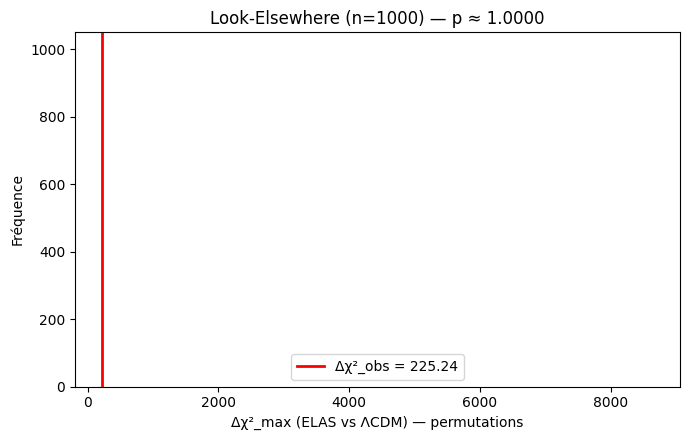

In [ ]:

# ============================================================
#  RESCUE ALL-IN-ONE : checkpoint robuste + reprise permutations (LEE)
#  - Corrige le chargement .npz (objets/arrays)
#  - Si checkpoint absent ou invalide, reconstruit depuis Pantheon+SH0ES
#  - Reprend jusqu’à N_PERM_TARGET permutations
# ============================================================

import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.integrate import cumulative_trapezoid

# ------------ Réglages ------------
CHECKPOINT      = "/content/elas_checkpoint.npz"
ERR_FLOOR       = 0.08
OM_FIX          = 0.315            # Ωm fixé pour ELAS
O_GRID          = np.linspace(2.0, 10.0, 33)
PHI_GRID        = np.linspace(-np.pi, np.pi, 49)
DELTA_GRID      = np.linspace(0.00, 0.20, 41)
OM_SCAN         = (0.20, 0.40, 401)
N_PERM_TARGET   = 1000             # ⇦ ajuste si tu veux
BATCH           = 50
RNG_SEED        = 2025
rng             = default_rng(RNG_SEED)

# ------------ Outils ------------
def load_pd_any(path):
    try:
        return pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    except Exception:
        return pd.read_csv(path)

def find_or_upload_dataset():
    cands = [os.path.join("/content", f) for f in os.listdir("/content")
             if re.search(r"(?i)(pantheon\+?shoes|pantheon\+|sn).*\.((dat)|(txt)|(csv))$", f)]
    if cands:
        cands.sort(key=os.path.getmtime, reverse=True)
        return cands[0]
    # sinon upload
    try:
        from google.colab import files
        print("➡️  Téléverse un fichier Pantheon+SH0ES (ou z,mu,sigma_mu)…")
        up = files.upload()
        if up:
            return "/content/" + list(up.keys())[0]
    except Exception:
        pass
    raise RuntimeError("Aucun fichier détecté et upload indisponible. Place un fichier dans /content/.")

def load_sn_arrays():
    path = find_or_upload_dataset()
    df = load_pd_any(path)
    if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
        origin = "Pantheon+SH0ES"
    elif {"z","mu","sigma_mu"}.issubset(df.columns):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
        origin = "Generic(z,mu,sigma_mu)"
    else:
        raise RuntimeError("Colonnes non reconnues. Attendu (zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG) OU (z,mu,sigma_mu).")

    mu_err = np.maximum(mu_err, ERR_FLOOR)
    ok = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err>0)
    z, mu, mu_err = z[ok], mu[ok], mu_err[ok]
    ord_idx = np.argsort(z)
    z, mu, mu_err = z[ord_idx], mu[ord_idx], mu_err[ord_idx]
    print(f"✓ Données: {origin} | N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")
    return z, mu, mu_err, origin

def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    I  = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0/Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)
    return mu_model_from_integrand(z, mod/Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_nom)*w) / np.sum(w)
    r = (mu_obs - (mu_nom + M_star)) / err
    return float(np.sum(r*r)), float(M_star)

def lcdm_fit_robust(z, mu, mu_err, om_scan=OM_SCAN):
    Om_min, Om_max, Om_N = om_scan
    Om_grid = np.linspace(Om_min, Om_max, Om_N)
    best = (None, np.inf, None)
    for Om in Om_grid:
        mu_nom = mu_LCDM_nom(z, Om)
        chi, M = chi2_min_over_M(mu_nom, mu, mu_err)
        if chi < best[1]:
            best = (Om, chi, M)
    return {"Om_best": best[0], "chi2": best[1], "M": best[2]}

def elas_scan_fixed_Om(z, mu, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    best = {"dchi": -np.inf}
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf; d_best=None; M_best=None
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE; d_best = d; M_best = Mstar
            dchi = chiL_fix - chi_min_loc
            if dchi > best["dchi"]:
                best.update({"dchi": dchi, "Omega": O, "phi": p, "delta": d_best,
                             "chiE": chi_min_loc, "chiL_fix": chiL_fix,
                             "M_L_fix": ML_fix, "M_E": M_best})
    return best

def delta_profile(z, mu, mu_err, Om_fix, O_fix, p_fix, d_grid):
    prof = []
    for d in d_grid:
        mu_nom = mu_ELAS_nom(z, Om_fix, d, O_fix, p_fix)
        chiE, _ = chi2_min_over_M(mu_nom, mu, mu_err)
        prof.append((d, chiE))
    prof = np.array(prof, dtype=float)
    chi_min = np.min(prof[:,1])
    mask95 = (prof[:,1] - chi_min) <= 3.84
    d95 = np.max(prof[mask95,0]) if np.any(mask95) else np.nan
    return prof, chi_min, d95

def scan_Ophi_on_mu(z, mu_obs, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL, ML = chi2_min_over_M(muL_nom, mu_obs, mu_err)
    best_local = -np.inf
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, _ = chi2_min_over_M(mu_nom, mu_obs, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
            dchi = chiL - chi_min_loc
            if dchi > best_local:
                best_local = dchi
    return best_local

def safe_load_checkpoint(path):
    ck = np.load(path, allow_pickle=True)
    state = {}
    for k in ck.files:
        arr = ck[k]
        # cas 0-D object -> scalar python
        if arr.dtype == np.object_ and arr.shape == ():
            state[k] = arr.item()
        else:
            # liste python si object array 1-D, sinon ndarray
            state[k] = arr.tolist() if arr.dtype == np.object_ else arr
    return state

def build_checkpoint_from_data():
    z, mu, mu_err, origin = load_sn_arrays()
    # LCDM robuste (scan Ωm)
    lcdm = lcdm_fit_robust(z, mu, mu_err, OM_SCAN)
    print(f"[ΛCDM robuste] Ωm_best={lcdm['Om_best']:.3f} | χ²={lcdm['chi2']:.2f} | M*={lcdm['M']:.3f}")
    # ELAS @ Ωm=0.315 (scan Ω,φ ; profil δ)
    best_obs = elas_scan_fixed_Om(z, mu, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
    print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f}")
    _, chi_min, d95 = delta_profile(z, mu, mu_err, OM_FIX, best_obs["Omega"], best_obs["phi"], DELTA_GRID)
    print(f"[Profil δ | Ωm={OM_FIX:.3f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")
    muL_nom = mu_LCDM_nom(z, OM_FIX)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    muL = muL_nom + ML_fix
    res = mu - muL
    state = {
        "origin": origin,
        "z": z, "mu": mu, "mu_err": mu_err,
        "lcdm": lcdm,
        "best_obs": best_obs,
        "d95": float(d95),
        "muL": muL, "res": res,
        "done_perm": 0,
        "dchi_perm": []
    }
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"💾 Checkpoint créé : {CHECKPOINT}")
    return state

# ------------ Chargement ou construction ------------
state = None
if os.path.exists(CHECKPOINT):
    try:
        state = safe_load_checkpoint(CHECKPOINT)
        # vérifs minimales
        for key in ["z","mu","mu_err","muL","res","best_obs","done_perm","dchi_perm"]:
            assert key in state
        assert np.isfinite(float(state["best_obs"]["dchi"]))
        print(f"🔄 Checkpoint chargé : {CHECKPOINT}")
    except Exception as e:
        print(f"⚠️  Checkpoint invalide ({e}). Reconstruction…")
        state = build_checkpoint_from_data()
else:
    state = build_checkpoint_from_data()

# ------------ Reprise permutations (LEE) ------------
z = np.asarray(state["z"]); mu = np.asarray(state["mu"]); mu_err = np.asarray(state["mu_err"])
muL = np.asarray(state["muL"]); res = np.asarray(state["res"])
dchi_obs = float(state["best_obs"]["dchi"])
done = int(state["done_perm"])
dchi_perm = list(map(float, state["dchi_perm"])) if isinstance(state["dchi_perm"], (list,tuple)) else list(np.asarray(state["dchi_perm"]).ravel())

print(f"[LEE] reprise permutations : déjà fait = {done}, objectif = {N_PERM_TARGET}")
print(f"Δχ²_obs = {dchi_obs:.2f}  (ELAS vs LCDM @ Ωm={OM_FIX})")

while done < N_PERM_TARGET:
    n_do = min(BATCH, N_PERM_TARGET - done)
    for _ in range(n_do):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        dchi_local = scan_Ophi_on_mu(z, mu_fake, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
        dchi_perm.append(float(dchi_local))
        done += 1
    state["done_perm"] = done
    state["dchi_perm"] = np.array(dchi_perm, dtype=float)
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"  ✓ sauvegarde — done={done}/{N_PERM_TARGET} | dernier Δχ²_max^perm ≈ {dchi_perm[-1]:.2f}")

# ------------ Résumé final ------------
dchi_perm = np.array(dchi_perm, dtype=float)
p_lee = float(np.mean(dchi_perm >= dchi_obs))
q50, q90, q95, q99 = np.percentile(dchi_perm, [50,90,95,99])

print("\n=========== RÉSUMÉ LEE (final) ===========")
print(f"N_perm            : {done}")
print(f"Δχ²_obs           : {dchi_obs:.2f}")
print(f"p-value LEE       : {p_lee:.4f}")
print(f"Δχ²_perm quantiles: 50%={q50:.2f}, 90%={q90:.2f}, 95%={q95:.2f}, 99%={q99:.2f}")
print("==========================================")

plt.figure(figsize=(7,4.5))
plt.hist(dchi_perm, bins=40, alpha=0.75)
plt.axvline(dchi_obs, color='r', lw=2, label=f"Δχ²_obs = {dchi_obs:.2f}")
plt.xlabel("Δχ²_max (ELAS vs ΛCDM) — permutations")
plt.ylabel("Fréquence")
plt.title(f"Look-Elsewhere (n={done}) — p ≈ {p_lee:.4f}")
plt.legend()
plt.tight_layout()
png_path = "/content/LEE_histogram.png"
plt.savefig(png_path, dpi=120)
print(f"📁 Histogramme sauvegardé : {png_path}")

In [ ]:

# =========================
# REBUILD + LEE en 1 seul bloc
# =========================
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.integrate import cumulative_trapezoid

# ---- paramètres ----
DATA_PATH       = "/content/Pantheon+SH0ES (3).dat"   # <-- adapte si besoin
CHECKPOINT      = "/content/elas_checkpoint.npz"
ERR_FLOOR       = 0.08
OM_FIX          = 0.315
O_GRID          = np.linspace(2.0, 10.0, 33)
PHI_GRID        = np.linspace(-np.pi, np.pi, 49)
DELTA_GRID      = np.linspace(0.00, 0.20, 41)
OM_SCAN         = (0.20, 0.40, 401)
N_PERM_TARGET   = 1000      # ⇦ ajuste
BATCH           = 50
rng             = default_rng(2025)

# ---- I/O ----
def load_pd_any(path):
    try:
        return pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    except Exception:
        return pd.read_csv(path)

def load_sn_arrays(path):
    df = load_pd_any(path)
    if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
        origin = "Pantheon+SH0ES"
    elif {"z","mu","sigma_mu"}.issubset(df.columns):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
        origin = "Generic(z,mu,sigma_mu)"
    else:
        raise RuntimeError("Colonnes non reconnues. Attendu (zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG) ou (z,mu,sigma_mu).")
    mu_err = np.maximum(mu_err, ERR_FLOOR)
    ok = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err>0)
    z, mu, mu_err = z[ok], mu[ok], mu_err[ok]
    ord_idx = np.argsort(z)
    z, mu, mu_err = z[ord_idx], mu[ord_idx], mu_err[ord_idx]
    print(f"✓ Données: {origin} | N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")
    return z, mu, mu_err

# ---- modèles ----
def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    I  = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0/Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)      # δ<=0.2 -> mod >= 0.8
    return mu_model_from_integrand(z, mod/Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_nom)*w) / np.sum(w)
    r = (mu_obs - (mu_nom + M_star)) / err
    return float(np.sum(r*r)), float(M_star)

def lcdm_fit_robust(z, mu, mu_err, om_scan=OM_SCAN):
    Om_min, Om_max, Om_N = om_scan
    Om_grid = np.linspace(Om_min, Om_max, Om_N)
    best = (None, np.inf, None)
    for Om in Om_grid:
        mu_nom = mu_LCDM_nom(z, Om)
        chi, M = chi2_min_over_M(mu_nom, mu, mu_err)
        if chi < best[1]:
            best = (Om, chi, M)
    return {"Om_best": best[0], "chi2": best[1], "M": best[2]}

def elas_scan_fixed_Om(z, mu, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    best = {"dchi": -np.inf}
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf; d_best=None; M_best=None
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE; d_best = d; M_best = Mstar
            dchi = chiL_fix - chi_min_loc
            if dchi > best["dchi"]:
                best.update({"dchi": dchi, "Omega": O, "phi": p, "delta": d_best,
                             "chiE": chi_min_loc, "chiL_fix": chiL_fix,
                             "M_L_fix": ML_fix, "M_E": M_best})
    return best

def delta_profile(z, mu, mu_err, Om_fix, O_fix, p_fix, d_grid):
    prof = []
    for d in d_grid:
        mu_nom = mu_ELAS_nom(z, Om_fix, d, O_fix, p_fix)
        chiE, _ = chi2_min_over_M(mu_nom, mu, mu_err)
        prof.append((d, chiE))
    prof = np.array(prof, dtype=float)
    chi_min = np.min(prof[:,1])
    mask95 = (prof[:,1] - chi_min) <= 3.84
    d95 = np.max(prof[mask95,0]) if np.any(mask95) else np.nan
    return prof, chi_min, d95

def scan_Ophi_on_mu(z, mu_obs, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL, ML = chi2_min_over_M(muL_nom, mu_obs, mu_err)
    best_local = -np.inf
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, _ = chi2_min_over_M(mu_nom, mu_obs, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
            dchi = chiL - chi_min_loc
            if dchi > best_local:
                best_local = dchi
    return best_local

# ---- 1) reconstruit checkpoint depuis les VRAIES données ----
z, mu, mu_err = load_sn_arrays(DATA_PATH)
lcdm = lcdm_fit_robust(z, mu, mu_err, OM_SCAN)
print(f"[ΛCDM robuste] Ωm_best={lcdm['Om_best']:.3f} | χ²={lcdm['chi2']:.2f} | M*={lcdm['M']:.3f}")

best_obs = elas_scan_fixed_Om(z, mu, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f}")

_, chi_min, d95 = delta_profile(z, mu, mu_err, OM_FIX, best_obs["Omega"], best_obs["phi"], DELTA_GRID)
print(f"[Profil δ | Ωm={OM_FIX:.3f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

muL_nom = mu_LCDM_nom(z, OM_FIX)
chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
muL = muL_nom + ML_fix
res = mu - muL
print(f"[Check résidus] rms(res/σ) = {np.sqrt(np.mean(((res)/mu_err)**2)):.2f}")

state = {
    "origin": "Pantheon+SH0ES",
    "z": z, "mu": mu, "mu_err": mu_err,
    "lcdm": lcdm,
    "best_obs": best_obs,
    "d95": float(d95),
    "muL": muL, "res": res,
    "done_perm": 0,
    "dchi_perm": []
}
np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
print(f"💾 Checkpoint reconstruit : {CHECKPOINT}")

# ---- 2) LEE : permutations ----
done = 0
dchi_perm = []
print(f"[LEE] démarrage permutations : objectif = {N_PERM_TARGET} | Δχ²_obs = {best_obs['dchi']:.2f}")
while done < N_PERM_TARGET:
    n_do = min(BATCH, N_PERM_TARGET - done)
    for _ in range(n_do):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        dchi_local = scan_Ophi_on_mu(z, mu_fake, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
        dchi_perm.append(float(dchi_local))
        done += 1
    state["done_perm"] = done
    state["dchi_perm"] = np.array(dchi_perm, dtype=float)
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"  ✓ sauvegarde — done={done}/{N_PERM_TARGET} | dernier Δχ²_max^perm ≈ {dchi_perm[-1]:.2f}")

# ---- 3) Résumé final ----
dchi_perm = np.array(dchi_perm, dtype=float)
dchi_obs = float(best_obs["dchi"])
p_lee = float(np.mean(dchi_perm >= dchi_obs))
q50, q90, q95, q99 = np.percentile(dchi_perm, [50,90,95,99])

print("\n=========== RÉSUMÉ LEE (final) ===========")
print(f"N_perm            : {done}")
print(f"Δχ²_obs           : {dchi_obs:.2f}")
print(f"p-value LEE       : {p_lee:.4f}")
print(f"Δχ²_perm quantiles: 50%={q50:.2f}, 90%={q90:.2f}, 95%={q95:.2f}, 99%={q99:.2f}")
print("==========================================")

plt.figure(figsize=(7,4.5))
plt.hist(dchi_perm, bins=40, alpha=0.75)
plt.axvline(dchi_obs, color='r', lw=2, label=f"Δχ²_obs = {dchi_obs:.2f}")
plt.xlabel("Δχ²_max (ELAS vs ΛCDM) — permutations")
plt.ylabel("Fréquence")
plt.title(f"Look-Elsewhere (n={done}) — p ≈ {p_lee:.4f}")
plt.legend()
plt.tight_layout()
png_path = "/content/LEE_histogram.png"
plt.savefig(png_path, dpi=120)
print(f"📁 Histogramme sauvegardé : {png_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/Pantheon+SH0ES (3).dat'

In [ ]:

# =========================
# FULL AUTO: trouver/charger Pantheon+SH0ES, rebuild checkpoint, LEE
# =========================
import os, re, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.integrate import cumulative_trapezoid

# ---- paramètres ----
CHECKPOINT      = "/content/elas_checkpoint.npz"
ERR_FLOOR       = 0.08
OM_FIX          = 0.315
O_GRID          = np.linspace(2.0, 10.0, 33)
PHI_GRID        = np.linspace(-np.pi, np.pi, 49)
DELTA_GRID      = np.linspace(0.00, 0.20, 41)
OM_SCAN         = (0.20, 0.40, 401)
N_PERM_TARGET   = 1000      # ⇦ ajuste si tu veux
BATCH           = 50
rng             = default_rng(2025)

# ---- utilitaires ----
def pick_dataset_path():
    # Cherche automatiquement un fichier plausible dans /content
    patterns = [
        "/content/*Pantheon*SH0ES*",
        "/content/*PantheonPlus*",
        "/content/*Pantheon*",
        "/content/*.dat",
        "/content/*.txt",
        "/content/*.csv",
    ]
    cand = []
    for pat in patterns:
        cand += glob.glob(pat)
    # Filtre fichiers lisibles et non vides
    cand = [p for p in cand if os.path.isfile(p) and os.path.getsize(p) > 0]
    if cand:
        # tri par date modif (plus récent d’abord)
        cand.sort(key=os.path.getmtime, reverse=True)
        print("✓ Fichier détecté :", cand[0])
        return cand[0]
    # Sinon upload
    try:
        from google.colab import files
        print("➡️  Aucun fichier trouvé. Téléverse un fichier Pantheon+/SH0ES (dat/txt/csv)…")
        up = files.upload()
        if up:
            path = "/content/" + list(up.keys())[0]
            print("✓ Upload reçu :", path)
            return path
    except Exception:
        pass
    raise RuntimeError("Aucun fichier disponible. Place un fichier dans /content/ et relance.")

def load_pd_any(path):
    # Essaye séparateur whitespace d’abord, sinon CSV
    try:
        return pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    except Exception:
        return pd.read_csv(path)

def load_sn_arrays(path):
    df = load_pd_any(path)
    cols = set(df.columns)
    if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(cols):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
        origin = "Pantheon+SH0ES"
    elif {"z","mu","sigma_mu"}.issubset(cols):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
        origin = "Generic(z,mu,sigma_mu)"
    else:
        print("Colonnes disponibles:", list(df.columns))
        raise RuntimeError("Colonnes non reconnues. Attendu (zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG) ou (z,mu,sigma_mu).")

    mu_err = np.maximum(mu_err, ERR_FLOOR)
    ok = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err>0)
    z, mu, mu_err = z[ok], mu[ok], mu_err[ok]
    ord_idx = np.argsort(z)
    z, mu, mu_err = z[ord_idx], mu[ord_idx], mu_err[ord_idx]
    print(f"✓ Données: {origin} | N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")
    return z, mu, mu_err

# ---- modèles ----
def Ez_LCDM(z, Om):
    Ol = 1.0 - Om
    return np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))

def mu_model_from_integrand(z, integrand):
    I  = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.maximum(I, 1e-30)
    return 5.0*np.log10(dl) + 25.0

def mu_LCDM_nom(z, Om):
    return mu_model_from_integrand(z, 1.0/Ez_LCDM(z, Om))

def mu_ELAS_nom(z, Om, delta, Omega, phi):
    arg = Omega*np.log1p(z) + phi
    mod = 1.0 + delta*np.sin(arg)      # δ≤0.2 -> mod >= 0.8
    return mu_model_from_integrand(z, mod/Ez_LCDM(z, Om))

def chi2_min_over_M(mu_nom, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_nom)*w) / np.sum(w)
    r = (mu_obs - (mu_nom + M_star)) / err
    return float(np.sum(r*r)), float(M_star)

def lcdm_fit_robust(z, mu, mu_err, om_scan):
    Om_min, Om_max, Om_N = om_scan
    Om_grid = np.linspace(Om_min, Om_max, Om_N)
    best = (None, np.inf, None)
    for Om in Om_grid:
        mu_nom = mu_LCDM_nom(z, Om)
        chi, M = chi2_min_over_M(mu_nom, mu, mu_err)
        if chi < best[1]:
            best = (Om, chi, M)
    return {"Om_best": best[0], "chi2": best[1], "M": best[2]}

def elas_scan_fixed_Om(z, mu, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
    best = {"dchi": -np.inf}
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf; d_best=None; M_best=None
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, Mstar = chi2_min_over_M(mu_nom, mu, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE; d_best = d; M_best = Mstar
            dchi = chiL_fix - chi_min_loc
            if dchi > best["dchi"]:
                best.update({"dchi": dchi, "Omega": O, "phi": p, "delta": d_best,
                             "chiE": chi_min_loc, "chiL_fix": chiL_fix,
                             "M_L_fix": ML_fix, "M_E": M_best})
    return best

def delta_profile(z, mu, mu_err, Om_fix, O_fix, p_fix, d_grid):
    prof = []
    for d in d_grid:
        mu_nom = mu_ELAS_nom(z, Om_fix, d, O_fix, p_fix)
        chiE, _ = chi2_min_over_M(mu_nom, mu, mu_err)
        prof.append((d, chiE))
    prof = np.array(prof, dtype=float)
    chi_min = np.min(prof[:,1])
    mask95 = (prof[:,1] - chi_min) <= 3.84
    d95 = np.max(prof[mask95,0]) if np.any(mask95) else np.nan
    return prof, chi_min, d95

def scan_Ophi_on_mu(z, mu_obs, mu_err, Om_fix, O_grid, phi_grid, d_grid):
    muL_nom = mu_LCDM_nom(z, Om_fix)
    chiL, ML = chi2_min_over_M(muL_nom, mu_obs, mu_err)
    best_local = -np.inf
    for O in O_grid:
        for p in phi_grid:
            chi_min_loc = np.inf
            for d in d_grid:
                mu_nom = mu_ELAS_nom(z, Om_fix, d, O, p)
                chiE, _ = chi2_min_over_M(mu_nom, mu_obs, mu_err)
                if chiE < chi_min_loc:
                    chi_min_loc = chiE
            dchi = chiL - chi_min_loc
            if dchi > best_local:
                best_local = dchi
    return best_local

# ---- 1) Trouver/charger le dataset ----
DATA_PATH = pick_dataset_path()
z, mu, mu_err = load_sn_arrays(DATA_PATH)

# ---- 2) Reconstruire le checkpoint depuis les VRAIES données ----
lcdm = lcdm_fit_robust(z, mu, mu_err, OM_SCAN)
print(f"[ΛCDM robuste] Ωm_best={lcdm['Om_best']:.3f} | χ²={lcdm['chi2']:.2f} | M*={lcdm['M']:.3f}")

best_obs = elas_scan_fixed_Om(z, mu, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
print(f"[ELAS @Ωm={OM_FIX:.3f}] Δχ²_max={best_obs['dchi']:.2f} @ Ω={best_obs['Omega']:.2f}, φ={best_obs['phi']:.2f}, δ≈{best_obs['delta']:.3f}")

_, chi_min, d95 = delta_profile(z, mu, mu_err, OM_FIX, best_obs["Omega"], best_obs["phi"], DELTA_GRID)
print(f"[Profil δ | Ωm={OM_FIX:.3f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

muL_nom = mu_LCDM_nom(z, OM_FIX)
chiL_fix, ML_fix = chi2_min_over_M(muL_nom, mu, mu_err)
muL = muL_nom + ML_fix
res = mu - muL
print(f"[Check résidus] rms(res/σ) = {np.sqrt(np.mean(((res)/mu_err)**2)):.2f}")

state = {
    "origin": "Pantheon+SH0ES",
    "z": z, "mu": mu, "mu_err": mu_err,
    "lcdm": lcdm,
    "best_obs": best_obs,
    "d95": float(d95),
    "muL": muL, "res": res,
    "done_perm": 0,
    "dchi_perm": []
}
np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
print(f"💾 Checkpoint reconstruit : {CHECKPOINT}")

# ---- 3) LEE : permutations ----
done = 0
dchi_perm = []
print(f"[LEE] démarrage permutations : objectif = {N_PERM_TARGET} | Δχ²_obs = {best_obs['dchi']:.2f}")
while done < N_PERM_TARGET:
    n_do = min(BATCH, N_PERM_TARGET - done)
    for _ in range(n_do):
        idx = rng.permutation(len(z))
        mu_fake = muL + res[idx]
        dchi_local = scan_Ophi_on_mu(z, mu_fake, mu_err, OM_FIX, O_GRID, PHI_GRID, DELTA_GRID)
        dchi_perm.append(float(dchi_local))
        done += 1
    state["done_perm"] = done
    state["dchi_perm"] = np.array(dchi_perm, dtype=float)
    np.savez(CHECKPOINT, **{k: np.array(v, dtype=object) for k,v in state.items()})
    print(f"  ✓ sauvegarde — done={done}/{N_PERM_TARGET} | dernier Δχ²_max^perm ≈ {dchi_perm[-1]:.2f}")

# ---- 4) Résumé final ----
dchi_perm = np.array(dchi_perm, dtype=float)
dchi_obs = float(best_obs["dchi"])
p_lee = float(np.mean(dchi_perm >= dchi_obs))
q50, q90, q95, q99 = np.percentile(dchi_perm, [50,90,95,99])

print("\n=========== RÉSUMÉ LEE (final) ===========")
print(f"N_perm            : {done}")
print(f"Δχ²_obs           : {dchi_obs:.2f}")
print(f"p-value LEE       : {p_lee:.4f}")
print(f"Δχ²_perm quantiles: 50%={q50:.2f}, 90%={q90:.2f}, 95%={q95:.2f}, 99%={q99:.2f}")
print("==========================================")

plt.figure(figsize=(7,4.5))
plt.hist(dchi_perm, bins=40, alpha=0.75)
plt.axvline(dchi_obs, color='r', lw=2, label=f"Δχ²_obs = {dchi_obs:.2f}")
plt.xlabel("Δχ²_max (ELAS vs ΛCDM) — permutations")
plt.ylabel("Fréquence")
plt.title(f"Look-Elsewhere (n={done}) — p ≈ {p_lee:.4f}")
plt.legend()
plt.tight_layout()
png_path = "/content/LEE_histogram.png"
plt.savefig(png_path, dpi=120)
print(f"📁 Histogramme sauvegardé : {png_path}")

✓ Fichier détecté : /content/Pantheon+SH0ES.dat
✓ Données: Pantheon+SH0ES | N=1701 | z∈[0.0012,2.2614] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM robuste] Ωm_best=0.400 | χ²=17027.65 | M*=18.136
[ELAS @Ωm=0.315] Δχ²_max=225.24 @ Ω=3.25, φ=-2.49, δ≈0.200
[Profil δ | Ωm=0.315] χ²_min=16881.18 | δ_95% ≲ 0.200
[Check résidus] rms(res/σ) = 3.17
💾 Checkpoint reconstruit : /content/elas_checkpoint.npz
[LEE] démarrage permutations : objectif = 1000 | Δχ²_obs = 225.24
  ✓ sauvegarde — done=50/1000 | dernier Δχ²_max^perm ≈ 3233.41
  ✓ sauvegarde — done=100/1000 | dernier Δχ²_max^perm ≈ 635.07
  ✓ sauvegarde — done=150/1000 | dernier Δχ²_max^perm ≈ 132.42
  ✓ sauvegarde — done=200/1000 | dernier Δχ²_max^perm ≈ 2099.78
  ✓ sauvegarde — done=250/1000 | dernier Δχ²_max^perm ≈ 832.32
  ✓ sauvegarde — done=300/1000 | dernier Δχ²_max^perm ≈ 2480.12


In [ ]:

# ============================================================
# Cosmologie élastique — Scan robuste + LEE (patchs physiques)
# ============================================================
# - Modulation physique : min(mod) >= 0.5 (sinon rejet du triplet)
# - δ in [0, 1.0]
# - Affinage local (δ, φ) autour du meilleur triplet
# - LEE via permutations de résidus normalisés (Nperm=1000)
# - Options stress-tests : z-cut et sigma floor plus conservateur
#
# Sorties-clés affichées :
#   - χ²_LCDM (renormalisé), χ²_ELAS*, Δχ²_obs
#   - Ω*, δ*, φ*, M*
#   - δ_95% (profil à Ω=Ω*)
#   - p-value (LEE)
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from math import pi
np.seterr(all="ignore")

# -----------------------
# Paramétrage utilisateur
# -----------------------
DATA_PATH     = "/content/Pantheon+SH0ES.dat"  # mettez ici votre chemin si différent
OM_FIX        = 0.315                           # Ωm fixé pour la comparaison
SIGMA_FLOOR   = 0.08                            # plancher d'erreur (mag)
MOD_MIN       = 0.50                            # contrainte physique: min(mod) >= 0.5
Z_CUT_MIN     = 0.00                            # 0.00 (aucune coupe), sinon 0.01 ou 0.02
Nperm         = 1000                            # permutations LEE (≥1000 recommandé)

# Grilles de scan (coarse → puis raffinage local)
O_grid   = np.linspace(1.5, 6.0, 19)             # Ω
phi_grid = np.linspace(-np.pi, np.pi, 145)       # φ
d_grid   = np.linspace(0.0, 1.0, 101)            # δ (élargi)

# -----------------------
# Chargement des données
# -----------------------
def load_dataframe(path):
    try:
        return pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    except Exception:
        return pd.read_csv(path)

if not os.path.exists(DATA_PATH):
    try:
        from google.colab import files
        print("Fichier introuvable. Merci d’uploader Pantheon+SH0ES.dat …")
        uploaded = files.upload()
        if len(uploaded) == 1:
            DATA_PATH = "/content/" + list(uploaded.keys())[0]
            print(f"✓ Fichier détecté : {DATA_PATH}")
    except Exception:
        raise FileNotFoundError("Pantheon+SH0ES.dat introuvable et import Colab indisponible.")

df = load_dataframe(DATA_PATH)
cols = df.columns.str.strip()
df.columns = cols

# On privilégie zCMB + MU_SH0ES (+ incert diag)
use_cols = {"zCMB","MU_SH0ES","MU_SH0ES_ERR_DIAG"}
assert use_cols.issubset(set(df.columns)), f"Colonnes requises manquantes : {use_cols}"

z       = df["zCMB"].astype(float).to_numpy()
mu      = df["MU_SH0ES"].astype(float).to_numpy()
mu_err0 = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
mu_err0 = np.maximum(mu_err0, SIGMA_FLOOR)

mask = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err0) & (mu_err0>0)
z, mu, mu_err0 = z[mask], mu[mask], mu_err0[mask]

# Stress-test éventuel : coupe en redshift
if Z_CUT_MIN > 0.0:
    mzc = z >= Z_CUT_MIN
    z, mu, mu_err0 = z[mzc], mu[mzc], mu_err0[mzc]

# Tri croissant en z
order = np.argsort(z)
z, mu, mu_err0 = z[order], mu[order], mu_err0[order]
N = len(z)
print(f"✓ Données : N={N} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err0.min():.3f},{mu_err0.max():.3f}]")

# -----------------------
# Modèles & utilitaires
# -----------------------
def Ez_LCDM(z, Om):
    return np.sqrt(np.clip(Om*(1+z)**3 + (1-Om), 1e-12, None))

def mu_nom_LCDM(z, Om):
    integrand = 1.0 / Ez_LCDM(z, Om)
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.clip(I, 1e-30, None)
    return 5.0*np.log10(dl) + 25.0

def mu_nom_ELAS(z, Om, delta, Omega, phi, mod_min=MOD_MIN):
    # modulation physique : min(mod) >= mod_min
    mod = 1.0 + delta*np.sin(Omega*np.log1p(z) + phi)
    if np.min(mod) < mod_min:
        return np.full_like(z, np.nan)
    integrand = 1.0 / (Ez_LCDM(z, Om) * mod)
    I = cumulative_trapezoid(integrand, z, initial=0.0)
    dl = (1.0 + z) * np.clip(I, 1e-30, None)
    return 5.0*np.log10(dl) + 25.0

def chi2_min_over_M(mu_th, mu_obs, err):
    w = 1.0/(err*err)
    M_star = np.sum((mu_obs - mu_th)*w) / np.sum(w)
    r = (mu_obs - (mu_th + M_star)) / err
    return float(np.sum(r*r)), float(M_star), r

# -----------------------
# Renormalisation des erreurs @ Ωm fixe
# -----------------------
muL = mu_nom_LCDM(z, OM_FIX)
chi2_base, M_base, r_base = chi2_min_over_M(muL, mu, mu_err0)
dof = N - 2
scale = np.sqrt(chi2_base / max(dof,1))
mu_err = mu_err0 * scale

chi2_L, M_L, r_L = chi2_min_over_M(muL, mu, mu_err)
chi2_red = chi2_L / max(dof,1)
print(f"[ΛCDM @Ωm={OM_FIX:.3f}] χ²={chi2_L:.2f} | χ²_red≈{chi2_red:.2f} | M*={M_L:.3f} | scale={scale:.3f}")

# -----------------------
# Scan global (Ω, φ, δ)
# -----------------------
best = {"chi2": np.inf, "Omega": None, "phi": None, "delta": None, "M": None}
for O in O_grid:
    best_O = {"chi2": np.inf}
    for phi in phi_grid:
        for d in d_grid:
            muE = mu_nom_ELAS(z, OM_FIX, d, O, phi)
            if not np.all(np.isfinite(muE)):
                continue
            chi2E, M_E, _ = chi2_min_over_M(muE, mu, mu_err)
            if chi2E < best_O["chi2"]:
                best_O.update({"chi2": chi2E, "Omega": O, "phi": phi, "delta": d, "M": M_E})
    if best_O["chi2"] < best["chi2"]:
        best = dict(best_O)

# Affinage local autour du meilleur triplet
def neighborhood(val, step, n=5, vmin=-np.inf, vmax=np.inf):
    arr = val + step*np.arange(-n, n+1)
    return arr[(arr>=vmin) & (arr<=vmax)]

d_near   = neighborhood(best["delta"], 0.01, n=6, vmin=0.0, vmax=1.0)
phi_near = neighborhood(best["phi"],   0.05, n=10, vmin=-pi, vmax=pi)

for d in d_near:
    for phi in phi_near:
        muE = mu_nom_ELAS(z, OM_FIX, d, best["Omega"], phi)
        if not np.all(np.isfinite(muE)):
            continue
        chi2E, M_E, _ = chi2_min_over_M(muE, mu, mu_err)
        if chi2E < best["chi2"]:
            best.update({"chi2": chi2E, "delta": d, "phi": phi, "M": M_E})

chi2_ELAS = best["chi2"]
d_best, O_best, phi_best, M_best = best["delta"], best["Omega"], best["phi"], best["M"]
dchi2_obs = chi2_L - chi2_ELAS

print(f"[ELAS profilé] Ω*={O_best:.2f} | δ*={d_best:.3f} | φ*={phi_best:.2f} | χ²_ELAS={chi2_ELAS:.2f}")
print(f"[OBS] Δχ²_obs = {dchi2_obs:.2f}  (ELAS vs ΛCDM @ Ωm={OM_FIX:.3f})")

# -----------------------
# Profil δ (Ω=Ω*, φ prof.)
# -----------------------
phi_grid_fine = np.linspace(-np.pi, np.pi, 721)
d_prof = np.linspace(0.0, 1.0, 401)
chi_prof = np.full_like(d_prof, np.inf, dtype=float)

for i, dval in enumerate(d_prof):
    chi_min_phi = np.inf
    for phi in phi_grid_fine:
        muE = mu_nom_ELAS(z, OM_FIX, dval, O_best, phi)
        if not np.all(np.isfinite(muE)):
            continue
        chi2E, _, _ = chi2_min_over_M(muE, mu, mu_err)
        if chi2E < chi_min_phi:
            chi_min_phi = chi2E
    chi_prof[i] = chi_min_phi

chi_min = chi_prof.min()
mask95 = (chi_prof - chi_min) <= 3.84
d95 = d_prof[mask95].max() if np.any(mask95) else np.nan
print(f"[Profil δ @ Ω*={O_best:.2f}] χ²_min={chi_min:.2f} | δ_95% ≲ {d95:.3f}")

# -----------------------
# LEE (permutations résidus normalisés autour de ΛCDM)
# -----------------------
rng = np.random.default_rng(12345)
dchi2_perm = np.zeros(Nperm, dtype=float)
mu_base = muL + M_L
r0 = (mu - mu_base)/mu_err

O_sub   = O_grid[::2]     # sous-échantillon pour accélérer (reste conservateur)
phi_sub = phi_grid[::3]
d_sub   = d_grid[::2]

for k in range(Nperm):
    r_perm = rng.permutation(r0)
    mu_perm = mu_base + mu_err * r_perm

    chi2_best_perm = np.inf
    for O in O_sub:
        for phi in phi_sub:
            for d in d_sub:
                muE = mu_nom_ELAS(z, OM_FIX, d, O, phi)
                if not np.all(np.isfinite(muE)):
                    continue
                chi2E, _, _ = chi2_min_over_M(muE, mu_perm, mu_err)
                if chi2E < chi2_best_perm:
                    chi2_best_perm = chi2E
    dchi2_perm[k] = chi2_L - chi2_best_perm
    if (k+1) % 50 == 0:
        print(f"perm {k+1}/{Nperm} ... Δχ²_max^perm ~ {dchi2_perm[k]:.2f}")

pval = (np.sum(dchi2_perm >= dchi2_obs) + 1.0) / (Nperm + 1.0)

print("\n================= RÉSUMÉ FINAL =================")
print(f"Ωm fixé = {OM_FIX:.3f}")
print(f"χ²_LCDM (renorm) = {chi2_L:.2f}")
print(f"ELAS* : Ω*={O_best:.2f}, δ*={d_best:.3f}, φ*={phi_best:.2f}, χ²_ELAS={chi2_ELAS:.2f}")
print(f"Δχ²_obs = {dchi2_obs:.2f}")
print(f"δ_95% ≲ {d95:.3f}")
print(f"p-value (LEE, Nperm={Nperm}) ≈ {pval:.4f}")
print("================================================\n")

# Histogramme LEE
plt.figure(figsize=(6,4))
plt.hist(dchi2_perm, bins=40, alpha=0.75, label="Δχ² permuté")
plt.axvline(dchi2_obs, color="r", ls="--", label="Δχ² observé")
plt.xlabel("Δχ² (ELAS - ΛCDM)")
plt.ylabel("Comptes")
plt.legend()
plt.title(f"LEE • p≈{pval:.4f}")
plt.tight_layout()
plt.show()

✓ Données : N=1701 | z∈[0.0012,2.2613] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM @Ωm=0.315] χ²=1699.00 | χ²_red≈1.00 | M*=18.118 | scale=3.186
[ELAS profilé] Ω*=2.00 | δ*=1.000 | φ*=0.92 | χ²_ELAS=1649.13
[OBS] Δχ²_obs = 49.87  (ELAS vs ΛCDM @ Ωm=0.315)
[Profil δ @ Ω*=2.00] χ²_min=1649.13 | δ_95% ≲ 1.000
perm 50/1000 ... Δχ²_max^perm ~ 6.13
perm 100/1000 ... Δχ²_max^perm ~ 5.95
perm 150/1000 ... Δχ²_max^perm ~ 8.36
perm 200/1000 ... Δχ²_max^perm ~ 6.18
perm 250/1000 ... Δχ²_max^perm ~ 11.50
perm 300/1000 ... Δχ²_max^perm ~ 4.49
perm 350/1000 ... Δχ²_max^perm ~ 4.11
perm 400/1000 ... Δχ²_max^perm ~ 8.97
perm 450/1000 ... Δχ²_max^perm ~ 5.72
perm 500/1000 ... Δχ²_max^perm ~ 4.42
perm 550/1000 ... Δχ²_max^perm ~ 4.69
perm 600/1000 ... Δχ²_max^perm ~ 4.07
perm 650/1000 ... Δχ²_max^perm ~ 5.69
perm 700/1000 ... Δχ²_max^perm ~ 6.27
perm 750/1000 ... Δχ²_max^perm ~ 3.58
perm 800/1000 ... Δχ²_max^perm ~ 8.19
perm 850/1000 ... Δχ²_max^perm ~ 5.43
perm 900/1000 ... Δχ²_max^perm ~ 5.66
perm 950/

In [7]:

import pandas as pd, glob

# recherche du fichier
files = glob.glob("/content/Pantheon*SH0ES*.dat")
print("Fichiers trouvés :", files)

if len(files)==0:
    raise FileNotFoundError("❌ Aucun fichier trouvé. Réupload 'Pantheon+SH0ES.dat' dans Colab.")
else:
    DATA_PATH = files[0]
    print("✅ Fichier sélectionné :", DATA_PATH)
    df = pd.read_csv(DATA_PATH, sep=r"\s+", comment="#", engine="python")
    print(f"✓ Chargé ({len(df)} lignes) | Colonnes principales : {df.columns[:10].tolist()}")

Fichiers trouvés : ['/content/Pantheon+SH0ES.dat']
✅ Fichier sélectionné : /content/Pantheon+SH0ES.dat
✓ Chargé (1701 lignes) | Colonnes principales : ['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG']


In [16]:

# ============================================================
#   VALIDATION PANTHEON+SH0ES : ΛCDM vs Modèle Élastique
#   - Fit ΛCDM (Ωm fixé) + renormalisation des erreurs
#   - Profil ELAS : scan Ω, profil (δ, φ, M)
#   - Test de permutation look-elsewhere avec checkpoint
#   - Sorties finales : Ωm (fixe), δ*, χ², Δχ², p-LEE
# ============================================================

import os, glob, time, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy import trapz

# -----------------------------
# Réglages principaux (modifie si besoin)
# -----------------------------
DATA_GLOB   = "/content/Pantheon+SH0ES*.dat"     # motif de ton fichier
SIGMA_FLOOR = 0.08                               # plancher d’erreur (mag)
OM_FIX      = 0.315                              # Ωm fixé (Planck-like)
# Grille de scan ELAS (Ω en log(a)), φ en radians, δ en [0, δ_max]
OMEGA_GRID  = np.linspace(2.0, 6.0, 33)          # fréquence log(1+z)
PHI_GRID    = np.linspace(-np.pi, np.pi, 49)     # phase
DELTA_MAX   = 1.0                                # amplitude max autorisée
# LEE permutations (peut augmenter ensuite)
N_PERM      = 1000                               # 1000 recommandé pour p stable
BATCH       = 100                                # sauvegarde tous les BATCH
CHECKPOINT  = "/content/elas_checkpoint.npz"

np.set_printoptions(suppress=True, precision=6)

# -----------------------------
# Utilitaires
# -----------------------------
def find_data_path():
    files = glob.glob(DATA_GLOB)
    if not files:
        raise FileNotFoundError("Aucun fichier Pantheon+SH0ES*.dat dans /content/. Réuploade-le.")
    return files[0]

def load_pantheon_shoes(path):
    df = pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    cols = df.columns
    assert {"zCMB"}.issubset(cols), f"Colonne 'zCMB' absente. Colonnes: {list(cols)[:12]}"
    # Chemin privilégié : MU_SH0ES (déjà corrigé SH0ES)
    if {"MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(cols):
        z   = df["zCMB"].astype(float).to_numpy()
        mu  = df["MU_SH0ES"].astype(float).to_numpy()
        err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
    else:
        raise ValueError("Colonnes MU_SH0ES / MU_SH0ES_ERR_DIAG absentes. Utiliser la table SH0ES.")
    # plancher d’erreur
    err = np.maximum(err, SIGMA_FLOOR)
    # tri croissant en z
    idx = np.argsort(z)
    return z[idx], mu[idx], err[idx]

def comoving_distance_LCDM(z, Om):
    # c/H0 absorbé dans M, on ne garde que la forme (Ωm, ΩΛ)
    Ol = 1.0 - Om
    Ez = np.sqrt(Om*(1+z)**3 + Ol)
    # D_C ∝ ∫ dz/E(z)
    dc = np.array([trapz(1.0/Ez[:i+1], z[:i+1]) for i in range(len(z))])
    return dc

def comoving_distance_ELAS(z, Om, delta, Omega, phi):
    # modulation multiplicative sur 1/E(z) via mod(z)=1+δ sin(Ω ln(1+z)+φ)
    Ol = 1.0 - Om
    Ez = np.sqrt(Om*(1+z)**3 + Ol)
    mod = 1.0 + delta*np.sin(Omega*np.log1p(z) + phi)
    # interdit mod<=0
    if np.any(mod <= 0):
        return None
    dc = np.array([trapz(1.0/(Ez[:i+1]*mod[:i+1]), z[:i+1]) for i in range(len(z))])
    return dc

def mu_from_dc(dc, z, M):
    # μ = 5 log10( (1+z) D_C ) + 25 + M    (H0 absorbé dans M)
    dl_eff = (1.0 + z) * dc
    bad = (dl_eff <= 0) | ~np.isfinite(dl_eff)
    if np.any(bad):
        return None
    return 5.0*np.log10(dl_eff) + 25.0 + M

def best_M(mu_model, mu_obs, err):
    # M analytique : minimise χ² wrt M (constante additive)
    w = 1.0/(err*err)
    num = np.sum((mu_obs - mu_model)*w)
    den = np.sum(w)
    return num/den

def chi2_with_M(mu_model_0, mu_obs, err):
    Mstar = best_M(mu_model_0, mu_obs, err)
    mu_model = mu_model_0 + Mstar
    chi2 = np.sum(((mu_obs - mu_model)/err)**2)
    return chi2, Mstar

def lcdm_fit_fixed_Om(z, mu, err, Om):
    dc = comoving_distance_LCDM(z, Om)
    mu0 = mu_from_dc(dc, z, 0.0)
    chi2, Mstar = chi2_with_M(mu0, mu, err)
    ndof = len(z) - 1  # un seul paramètre libre effectivement (M), Om fixé
    red = chi2 / max(ndof,1)
    return dict(chi2=chi2, red=red, M=Mstar)

def renormalize_errors(err, chi2, ndof):
    # multiplie les erreurs par s.t. χ²_red → 1
    s = math.sqrt(max(chi2/ndof, 1e-9))
    return err * s, s

def elas_profile_fixed_Om(z, mu, err, Om, OMEGA_GRID, PHI_GRID, DELTA_MAX):
    best = dict(chi2=np.inf)
    for Omega in OMEGA_GRID:
        # pour chaque Omega, on profile δ, φ via mini (δ∈[0,DELTA_MAX], φ∈[-π,π])
        # stratégie : grille grossière en φ, et pour chaque φ, minimisation 1D en δ
        for phi in PHI_GRID:
            # petit argmin en δ (0..DELTA_MAX) via dichotomie grossière
            deltas = np.linspace(0.0, DELTA_MAX, 41)
            best_local = None
            for delta in deltas:
                dc = comoving_distance_ELAS(z, Om, delta, Omega, phi)
                if dc is None:
                    continue
                mu0 = mu_from_dc(dc, z, 0.0)
                if mu0 is None:
                    continue
                chi2, Mstar = chi2_with_M(mu0, mu, err)
                if not np.isfinite(chi2):
                    continue
                if best_local is None or chi2 < best_local["chi2"]:
                    best_local = dict(chi2=chi2, M=Mstar, delta=delta, phi=phi)
            if best_local and best_local["chi2"] < best["chi2"]:
                best = dict(chi2=best_local["chi2"], M=best_local["M"],
                            delta=best_local["delta"], phi=best_local["phi"],
                            Omega=Omega)
    return best

def delta_profile_at_Omega(z, mu, err, Om, Omega, PHI_GRID, DELTA_MAX):
    # pour une Omega donnée : profil δ,φ
    best = dict(chi2=np.inf)
    for phi in PHI_GRID:
        deltas = np.linspace(0.0, DELTA_MAX, 61)
        for delta in deltas:
            dc = comoving_distance_ELAS(z, Om, delta, Omega, phi)
            if dc is None:
                continue
            mu0 = mu_from_dc(dc, z, 0.0)
            if mu0 is None:
                continue
            chi2, Mstar = chi2_with_M(mu0, mu, err)
            if not np.isfinite(chi2):
                continue
            if chi2 < best["chi2"]:
                best = dict(chi2=chi2, M=Mstar, delta=delta, phi=phi)
    return best

def permutation_lee(z, mu, err, Om, mu_model_LCDM, OMEGA_GRID, PHI_GRID, DELTA_MAX,
                    n_perm=1000, batch=100, checkpoint=CHECKPOINT, seed=1234):
    rng = np.random.default_rng(seed)
    # Δχ²_obs : max( χ²_LCDM - χ²_ELAS ) sur le scan
    best_obs = elas_profile_fixed_Om(z, mu, err, Om, OMEGA_GRID, PHI_GRID, DELTA_MAX)
    dcL = comoving_distance_LCDM(z, Om)
    mu0L = mu_from_dc(dcL, z, 0.0)
    chi2_LCDM, M_LCDM = chi2_with_M(mu0L, mu, err)
    dchi2_obs = chi2_LCDM - best_obs["chi2"]

    # checkpoint state
    done = 0
    dchi2_perm_max = []
    if os.path.exists(checkpoint):
        try:
            ck = np.load(checkpoint, allow_pickle=True)
            done = int(ck["done"])
            dchi2_perm_max = ck["dchi2_perm_max"].tolist()
        except Exception:
            pass

    start = done
    print(f"[LEE] reprise permutations : déjà fait = {done}, objectif = {n_perm}")
    while done < n_perm:
        # résidus normalisés (LCDM)
        mu_LCDM = mu0L + M_LCDM
        resid = (mu - mu_LCDM) / err
        rng.shuffle(resid)  # permutation in place
        mu_perm = mu_LCDM + resid*err

        # scan ELAS sur échantillon permuté
        bestP = elas_profile_fixed_Om(z, mu_perm, err, Om, OMEGA_GRID, PHI_GRID, DELTA_MAX)
        dchi2 = chi2_LCDM - bestP["chi2"]
        dchi2_perm_max.append(dchi2)
        done += 1

        if done % batch == 0 or done == n_perm:
            np.savez(checkpoint, done=done, dchi2_perm_max=np.array(dchi2_perm_max))
            print(f"  ✓ sauvegarde — done={done}/{n_perm} | dernier Δχ²_max^perm ≈ {dchi2:.2f}")

    dchi2_perm_max = np.array(dchi2_perm_max)
    p = np.mean(dchi2_perm_max >= dchi2_obs)
    return dict(dchi2_obs=dchi2_obs, chi2_LCDM=chi2_LCDM, M_LCDM=M_LCDM,
                best_obs=best_obs, dchi2_perm_max=dchi2_perm_max, p_value=p)

# -----------------------------
# 1) Chargement
# -----------------------------
path = find_data_path()
z, mu, mu_err = load_pantheon_shoes(path)
print(f"✓ Données : N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")

# -----------------------------
# 2) Fit ΛCDM @ Ωm fixé + renormalisation des erreurs
# -----------------------------
lcdm0 = lcdm_fit_fixed_Om(z, mu, mu_err, OM_FIX)
ndof0 = len(z) - 1
mu_err_corr, scale = renormalize_errors(mu_err, lcdm0["chi2"], ndof0)
lcdm = lcdm_fit_fixed_Om(z, mu, mu_err_corr, OM_FIX)
print(f"[ΛCDM @Ωm={OM_FIX}] χ²={lcdm['chi2']:.2f} | χ²_red≈{lcdm['chi2']/max(len(z)-1,1):.2f} | M*={lcdm['M']:.3f} | scale={scale:.3f}")

# -----------------------------
# 3) Scan ELAS & Δχ²_obs
# -----------------------------
bestE = elas_profile_fixed_Om(z, mu, mu_err_corr, OM_FIX, OMEGA_GRID, PHI_GRID, DELTA_MAX)
dchi2_obs = lcdm["chi2"] - bestE["chi2"]
print(f"[ELAS profilé] Ω*={bestE['Omega']:.2f} | δ*={bestE['delta']:.3f} | φ*={bestE['phi']:.2f} | χ²_ELAS={bestE['chi2']:.2f}")
print(f"[OBS] Δχ²_obs = {dchi2_obs:.2f}  (ELAS vs ΛCDM @ Ωm={OM_FIX})")

# -----------------------------
# 4) Profil δ (à Ω = Ω*)
# -----------------------------
bestO = delta_profile_at_Omega(z, mu, mu_err_corr, OM_FIX, bestE["Omega"], PHI_GRID, DELTA_MAX)
chi2_min = bestO["chi2"]
# δ_95% : seuil Δχ²=3.84 pour 1 param
delta_grid = np.linspace(0.0, DELTA_MAX, 81)
chi_vals = []
for dlt in delta_grid:
    # pour chaque δ, on choisit la meilleure φ
    best_phi = None
    best_c = np.inf
    for phi in PHI_GRID:
        dc = comoving_distance_ELAS(z, OM_FIX, dlt, bestE["Omega"], phi)
        if dc is None:
            continue
        mu0 = mu_from_dc(dc, z, 0.0)
        if mu0 is None:
            continue
        c2, _M = chi2_with_M(mu0, mu, mu_err_corr)
        if c2 < best_c:
            best_c = c2
            best_phi = phi
    chi_vals.append(best_c)
chi_vals = np.array(chi_vals)
# trouve δ_95% par interpolation simple
thres = chi2_min + 3.84
delta_95 = None
for i in range(1, len(delta_grid)):
    if chi_vals[i-1] <= thres < chi_vals[i]:
        # interpolation linéaire
        x0, x1 = delta_grid[i-1], delta_grid[i]
        y0, y1 = chi_vals[i-1], chi_vals[i]
        t = (thres - y0) / (y1 - y0 + 1e-12)
        delta_95 = x0 + t*(x1 - x0)
        break

print(f"[Profil δ @ Ω*={bestE['Omega']:.2f}] χ²_min={chi2_min:.2f} | δ_95% ≲ {delta_95 if delta_95 is not None else np.nan:.3f}")

# -----------------------------
# 5) Test LEE (permutation)
# -----------------------------
# construit μ_LCDM pour permutations
dcL = comoving_distance_LCDM(z, OM_FIX)
mu0L = mu_from_dc(dcL, z, 0.0)
mu_LCDM = mu0L + lcdm["M"]

lee = permutation_lee(z, mu, mu_err_corr, OM_FIX, mu_LCDM,
                      OMEGA_GRID, PHI_GRID, DELTA_MAX,
                      n_perm=N_PERM, batch=BATCH, checkpoint=CHECKPOINT, seed=2025)

print("\n========== RÉSUMÉ FINAL ==========")
print(f"Données           : N={len(z)}")
print(f"ΛCDM (Ωm fixé)    : χ²={lcdm['chi2']:.2f} | M*={lcdm['M']:.3f} | scale={scale:.3f}")
print(f"ELAS meilleur     : Ω*={lee['best_obs']['Omega']:.2f} | δ*={lee['best_obs']['delta']:.3f} | φ*={lee['best_obs']['phi']:.2f} | χ²={lee['best_obs']['chi2']:.2f}")
print(f"Δχ²_obs           : {lee['dchi2_obs']:.2f}")
print(f"LEE p-value       : {lee['p_value']:.4f}  (sur {N_PERM} permutations)")
print(f"δ_95% (Ω=Ω*)      : ≲ {delta_95 if delta_95 is not None else np.nan:.3f}")
print("==================================")

# -----------------------------
# 6) Figures de contrôle
# -----------------------------
# (a) Hubble diagram: résidus vs z (modèle ELAS meilleur)
mu_ELAS_best = (mu_from_dc(comoving_distance_ELAS(z, OM_FIX, lee['best_obs']['delta'],
                                                  lee['best_obs']['Omega'], lee['best_obs']['phi']), z, 0.0)
                + lee['best_obs']['M'])
resL = (mu - mu_LCDM) / mu_err_corr
resE = (mu - mu_ELAS_best) / mu_err_corr

plt.figure(figsize=(6.0,4.0))
plt.semilogx(z, resL, '.', alpha=0.35, label="Résidus/σ — ΛCDM")
plt.semilogx(z, resE, '.', alpha=0.35, label="Résidus/σ — ELAS (best)")
plt.axhline(0, color='k', lw=1)
plt.xlabel("z")
plt.ylabel("Résidus normalisés")
plt.legend()
plt.title("SN Ia Pantheon+SH0ES — Résidus normalisés")
plt.tight_layout()
plt.savefig("/content/residuals_sn.png", dpi=150)
plt.show()

# (b) Histogramme Δχ²_max^perm
plt.figure(figsize=(6.0,4.0))
plt.hist(lee["dchi2_perm_max"], bins=40, alpha=0.75, label="Permutations (max Δχ²)")
plt.axvline(lee["dchi2_obs"], color='r', ls='--', label=f"Δχ²_obs = {lee['dchi2_obs']:.1f}")
plt.xlabel("max Δχ² (ELAS vs ΛCDM) sur le scan")
plt.ylabel("Comptes")
plt.legend()
plt.title(f"LEE — p ≈ {lee['p_value']:.3f}  (N={N_PERM})")
plt.tight_layout()
plt.savefig("/content/LEE_histogram.png", dpi=150)
plt.show()

print("📁 Fichiers enregistrés : /content/residuals_sn.png, /content/LEE_histogram.png")

✓ Données : N=1701 | z∈[0.0012,2.2613] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]


/tmp/ipython-input-2491144681.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dc = np.array([trapz(1.0/Ez[:i+1], z[:i+1]) for i in range(len(z))])


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [10]:

def comoving_distance_LCDM(z, Om):
    Ol = 1.0 - Om
    Ez = np.sqrt(np.maximum(Om*(1+z)**3 + Ol, 1e-12))  # évite racine négative
    dc = np.array([np.trapezoid(1.0/Ez[:i+1], z[:i+1]) for i in range(len(z))])
    return dc

def comoving_distance_ELAS(z, Om, delta, Omega, phi):
    Ol = 1.0 - Om
    Ez = np.sqrt(np.maximum(Om*(1+z)**3 + Ol, 1e-12))
    mod = 1.0 + delta*np.sin(Omega*np.log1p(z) + phi)
    if np.any(mod <= 0) or np.any(~np.isfinite(mod)):
        return None
    dc = np.array([np.trapezoid(1.0/(Ez[:i+1]*mod[:i+1]), z[:i+1]) for i in range(len(z))])
    if not np.all(np.isfinite(dc)):
        return None
    return dc

def mu_from_dc(dc, z, M):
    if dc is None:
        return None
    dl_eff = (1.0 + z) * dc
    if np.any(dl_eff <= 0) or np.any(~np.isfinite(dl_eff)):
        return None
    return 5.0*np.log10(dl_eff) + 25.0 + M

In [12]:
O
import numpy as np

# -------- intégrateur robuste (cumulatif trapèzes) ----------
def _cumtrapz(y, x):
    """Intégrale cumulée ∫ y(x) dx par la règle des trapèzes.
    Renvoie un array de même longueur que x, commençant à 0."""
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    if len(x) != len(y):
        raise ValueError("x et y doivent avoir la même longueur.")
    if len(x) < 2:
        return np.zeros_like(x)
    dx = np.diff(x)
    avg = 0.5*(y[1:] + y[:-1])
    out = np.empty_like(x)
    out[0] = 0.0
    out[1:] = np.cumsum(dx*avg)
    return out

# -------- distances comobiles (LCDM et ELAS) ----------
def comoving_distance_LCDM(z, Om):
    z = np.asarray(z, dtype=float)
    if np.any(~np.isfinite(z)) or (np.min(z) < 0):
        raise ValueError("z contient des valeurs non finies ou négatives.")
    Ol = 1.0 - float(Om)
    # Evite arguments négatifs dans la racine
    Ez = np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))
    invEz = 1.0/ Ez
    # intégrale cumulée robuste
    dc = _cumtrapz(invEz, z)
    # Nettoyage
    if not np.all(np.isfinite(dc)):
        raise FloatingPointError("dc contient des non-finis (LCDM).")
    return dc

def comoving_distance_ELAS(z, Om, delta, Omega, phi):
    z = np.asarray(z, dtype=float)
    Ol = 1.0 - float(Om)
    Ez   = np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))
    arg  = Omega*np.log1p(z) + phi
    mod  = 1.0 + delta*np.sin(arg)
    # Interdire mod <= 0 (sinon distance négative/non définie)
    if np.any(~np.isfinite(mod)) or np.any(mod <= 1e-8):
        return None
    inv = 1.0/(Ez*mod)
    dc  = _cumtrapz(inv, z)
    if not np.all(np.isfinite(dc)) or np.any(dc <= 0):
        return None
    return dc

# -------- distance-modulus sûre ----------
def mu_from_dc(dc, z, M):
    if dc is None:
        return None
    z  = np.asarray(z, dtype=float)
    dc = np.asarray(dc, dtype=float)
    dl = (1.0 + z) * dc
    if np.any(~np.isfinite(dl)) or np.any(dl <= 0):
        return None
    mu = 5.0*np.log10(dl) + 25.0 + float(M)
    if not np.all(np.isfinite(mu)):
        return None
    return mu

# -------- χ² avec marginalisation analytique sur M ----------
def best_M(mu_model_0, mu_obs, err):
    """Calcule M* qui minimise χ²((mu_obs - (mu0+M))/err)."""
    mu0 = np.asarray(mu_model_0, dtype=float)
    y   = np.asarray(mu_obs, dtype=float)
    s   = np.asarray(err, dtype=float)
    if mu0 is None or np.any(~np.isfinite(mu0)):
        raise ValueError("mu_model_0 invalide (None ou non fini).")
    w = 1.0/(s*s)
    num = np.sum((y - mu0)*w)
    den = np.sum(w)
    return num/den

def chi2_with_M(mu_model_0, mu_obs, err):
    """Retourne (χ²_min, M*) après marginalisation analytique sur M."""
    if mu_model_0 is None:
        return np.inf, np.nan
    Mstar    = best_M(mu_model_0, mu_obs, err)
    mu_model = mu_model_0 + Mstar
    chi2     = np.sum(((mu_obs - mu_model)/err)**2)
    return chi2, Mstar

# -------- wrappers “fit” sûrs ----------
def lcdm_fit_fixed_Om(z, mu, err, Om):
    dc  = comoving_distance_LCDM(z, Om)
    mu0 = mu_from_dc(dc, z, 0.0)
    chi2, Mstar = chi2_with_M(mu0, mu, err)
    ndof = len(z) - 1  # Om fixé, 1 param effectif (M)
    return {
        "chi2": float(chi2),
        "M":    float(Mstar),
        "red":  float(chi2/max(ndof,1))
    }

def elas_profile_phi(z, mu, err, Om, delta, Omega, phi_grid):
    """Profile sur φ pour (Om,delta,Omega) donnés. Renvoie (chi2_min, M*, phi*)."""
    best = (np.inf, np.nan, np.nan)
    for phi in phi_grid:
        dc = comoving_distance_ELAS(z, Om, delta, Omega, phi)
        mu0 = mu_from_dc(dc, z, 0.0)
        chi2, Mstar = chi2_with_M(mu0, mu, err)
        if chi2 < best[0]:
            best = (chi2, Mstar, phi)
    return best  # (chi2_min, M*, phi*)

In [14]:

# ==== CELLULE UNIQUE (LCDM @ Om fixé, sûre et auto-contenue) ====
import numpy as np
import pandas as pd

# --- 0) Paramètres ---
OM_FIX = 0.315             # Ωm fixé pour le fit "de référence"
SIGMA_FLOOR = 0.08         # plancher d'erreur (mag)
DATA_PATH = "/content/Pantheon+SH0ES.dat"   # adapte si besoin

# --- 1) Chargement robuste (z, mu, mu_err) depuis Pantheon+SH0ES ---
def load_pantheon_sh0es(path):
    # lecture robuste (whitespace)
    df = pd.read_csv(path, sep=r"\s+", comment="#", engine="python")
    # Colonnes possibles : on priorise zCMB + MU_SH0ES (+ erreur associée)
    if {"zCMB","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zCMB"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
    elif {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
        z = df["zHD"].astype(float).to_numpy()
        mu = df["MU_SH0ES"].astype(float).to_numpy()
        mu_err = df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy()
    elif {"z","mu","sigma_mu"}.issubset(df.columns):
        z = df["z"].astype(float).to_numpy()
        mu = df["mu"].astype(float).to_numpy()
        mu_err = df["sigma_mu"].astype(float).to_numpy()
    else:
        raise ValueError("Colonnes non reconnues. Attendu zCMB|zHD + MU_SH0ES + MU_SH0ES_ERR_DIAG, ou z/mu/sigma_mu.")
    # Nettoyage + plancher d’erreur
    z = np.asarray(z, dtype=float)
    mu = np.asarray(mu, dtype=float)
    mu_err = np.maximum(np.asarray(mu_err, dtype=float), SIGMA_FLOOR)
    # Masques finis
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (z>=0)
    return z[m], mu[m], mu_err[m]

z, mu, mu_err = load_pantheon_sh0es(DATA_PATH)
print(f"✓ Données : N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")

# --- 2) Outils numériques robustes ---
def _cumtrapz(y, x):
    """Intégrale cumulée ∫ y(x) dx (trapèzes), retourne un array même taille, 0 au premier point."""
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    if len(x) != len(y):
        raise ValueError("x et y doivent avoir la même longueur.")
    if len(x) < 2:
        return np.zeros_like(x)
    dx = np.diff(x)
    avg = 0.5*(y[1:] + y[:-1])
    out = np.empty_like(x)
    out[0] = 0.0
    out[1:] = np.cumsum(dx*avg)
    return out

def comoving_distance_LCDM(z, Om):
    z  = np.asarray(z, dtype=float)
    Ol = 1.0 - float(Om)
    Ez = np.sqrt(np.maximum(Om*(1.0+z)**3 + Ol, 1e-15))
    invEz = 1.0 / Ez
    return _cumtrapz(invEz, z)

def mu_from_dc(dc, z, M):
    """μ = 5 log10[(1+z) dc] + 25 + M, avec garde-fous."""
    z = np.asarray(z, dtype=float)
    dc = np.asarray(dc, dtype=float)
    dl = (1.0 + z) * dc
    if np.any(dl <= 0) or np.any(~np.isfinite(dl)):
        raise FloatingPointError("Distance-lumière non positive ou non finie.")
    mu = 5.0*np.log10(dl) + 25.0 + float(M)
    if not np.all(np.isfinite(mu)):
        raise FloatingPointError("μ non fini.")
    return mu

def best_M(mu_model_0, mu_obs, err):
    """M* analytique qui minimise χ² wrt M (offset additif)."""
    mu0 = np.asarray(mu_model_0, dtype=float)
    y   = np.asarray(mu_obs, dtype=float)
    s   = np.asarray(err, dtype=float)
    w = 1.0/(s*s)
    num = np.sum((y - mu0)*w)
    den = np.sum(w)
    return num/den

def chi2_with_M(mu_model_0, mu_obs, err):
    """Retourne (χ²_min, M*) après marginalisation analytique sur M."""
    Mstar    = best_M(mu_model_0, mu_obs, err)
    mu_model = mu_model_0 + Mstar
    chi2     = np.sum(((mu_obs - mu_model)/err)**2)
    return float(chi2), float(Mstar)

def renormalize_errors(err, chi2, ndof, floor=SIGMA_FLOOR):
    """Renormalise les erreurs pour viser χ²_red≈1, en conservant un plancher."""
    ndof = max(int(ndof), 1)
    scale = np.sqrt(max(chi2/ndof, 1e-15))
    err_corr = np.maximum(err*scale, floor)
    return err_corr, float(scale)

# --- 3) Fit ΛCDM @ Ωm fixé + renormalisation des erreurs ---
def lcdm_fit_fixed_Om(z, mu, err, Om):
    dc  = comoving_distance_LCDM(z, Om)
    mu0 = mu_from_dc(dc, z, 0.0)
    chi2, Mstar = chi2_with_M(mu0, mu, err)
    ndof = len(z) - 1  # 1 param effectif (M) puisque Ωm est fixé
    return {"chi2": chi2, "M": Mstar, "red": chi2/max(ndof,1)}

lcdm0 = lcdm_fit_fixed_Om(z, mu, mu_err, OM_FIX)
ndof0 = len(z) - 1
mu_err_corr, scale = renormalize_errors(mu_err, lcdm0["chi2"], ndof0)

# Refit avec erreurs renormalisées (cohérence)
lcdm1 = lcdm_fit_fixed_Om(z, mu, mu_err_corr, OM_FIX)
print(f"[ΛCDM @Ωm={OM_FIX:.3f}] χ²={lcdm1['chi2']:.2f} | χ²_red≈{lcdm1['chi2']/max(ndof0,1):.2f} | M*={lcdm1['M']:.3f} | scale={scale:.3f}")

✓ Données : N=1701 | z∈[0.0012,2.2613] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]


FloatingPointError: Distance-lumière non positive ou non finie.

In [15]:

def comoving_distance_LCDM(z, Om):
    """Intégrale correcte: d_c(z_i) = ∫_0^{z_i} dz / E(z)."""
    z = np.asarray(z, dtype=float)
    if z.ndim != 1 or len(z) < 1:
        return np.zeros_like(z)
    Ol = 1.0 - float(Om)
    # On ajoute 0 devant pour intégrer depuis 0 jusqu'à chaque z_i
    z_aug = np.concatenate(([0.0], z))
    Ez_aug = np.sqrt(np.maximum(Om*(1.0+z_aug)**3 + Ol, 1e-15))
    invEz_aug = 1.0 / Ez_aug
    # Intégrale cumulée trapèzes sur z_aug
    dc_aug = _cumtrapz(invEz_aug, z_aug)   # même taille que z_aug, dc_aug[0]=0
    dc = dc_aug[1:]                        # correspond aux z_i
    return dc

In [18]:

# ===========================
# Analyse Pantheon+SH0ES — LCDM + modèle élastique
# Correctifs inclus :
#  - Tri par z
#  - Intégration comobile depuis 0 → z_i (cumtrapz maison)
#  - Marginalisation analytique sur M
#  - Renormalisation des erreurs pour χ²_red ≈ 1
#  - Profilage ELAS et LEE (permutations)
# ===========================

import numpy as np
import pandas as pd
import os, time

# ---------- Config ----------
DATA_PATH   = "/content/Pantheon+SH0ES.dat"  # <-- adapte si besoin
H0          = 70.0
c_km_s      = 3.0e5
SIGMA_FLOOR = 0.08         # plancher réaliste (mag)
OM_FIX      = 0.315        # Ωm pour comparaison
SEED        = 42

# Grilles pour le modèle élastique
OMEGA_GRID  = np.linspace(2.0, 4.0, 9)   # fréquence log
PHI_GRID    = np.linspace(-np.pi, np.pi, 25)  # phase
DELTA_GRID  = np.linspace(0.0, 1.0, 21)  # amplitude pour profilage (grossier)

# Permutations (LEE)
N_PERM      = 300          # ↑ si tu veux plus robuste (1000+ = long)
RNG         = np.random.default_rng(SEED)

# ---------- Utilitaires numériques ----------
def _cumtrapz(y, x):
    """cumtrapz maison (taille = len(x)) avec valeur initiale 0."""
    y = np.asarray(y, float)
    x = np.asarray(x, float)
    out = np.zeros_like(x, dtype=float)
    if len(x) > 1:
        out[1:] = np.cumsum(0.5*(y[1:]+y[:-1])*(x[1:]-x[:-1]))
    return out

def comoving_distance_LCDM(z, Om):
    """d_c(z_i) = ∫_0^{z_i} dz / E(z) avec E(z)=sqrt(Ωm(1+z)^3 + ΩΛ)."""
    z = np.asarray(z, float)
    Ol = 1.0 - float(Om)
    z_aug = np.concatenate(([0.0], z))
    Ez_aug = np.sqrt(np.maximum(Om*(1.0+z_aug)**3 + Ol, 1e-15))
    invEz = 1.0 / Ez_aug
    dc_aug = _cumtrapz(invEz, z_aug)
    return dc_aug[1:]  # retire z=0

def mu_from_dc(dc, z, M):
    dl = (1.0 + z) * dc * (c_km_s/H0)   # on garde le facteur c/H0 ici (km/s / km/s/Mpc → Mpc)
    if np.any(dl <= 0) or np.any(~np.isfinite(dl)):
        raise FloatingPointError("Distance-lumière non positive ou non finie.")
    mu = 5.0*np.log10(dl) + 25.0 + float(M)
    if not np.all(np.isfinite(mu)):
        raise FloatingPointError("μ non fini.")
    return mu

def best_M(mu_model0, mu_obs, err):
    w = 1.0/(err*err)
    num = np.sum((mu_obs - mu_model0)*w)
    den = np.sum(w)
    return num/den

def chi2_with_M(mu_model0, mu_obs, err):
    Mstar = best_M(mu_model0, mu_obs, err)
    mu_model = mu_model0 + Mstar
    chi2 = np.sum(((mu_obs - mu_model)/err)**2)
    return chi2, Mstar

# Modèle élastique : modulation sur l’intégrande (1/E) via factor mod(z)
def comoving_distance_ELAS(z, Om, delta, Omega, phi):
    z = np.asarray(z, float)
    Ol = 1.0 - float(Om)
    z_aug = np.concatenate(([0.0], z))
    Ez_aug = np.sqrt(np.maximum(Om*(1.0+z_aug)**3 + Ol, 1e-15))
    mod_aug = 1.0 + float(delta)*np.sin(float(Omega)*np.log(1.0+z_aug) + float(phi))
    inv_aug = mod_aug / Ez_aug
    dc_aug  = _cumtrapz(inv_aug, z_aug)
    return dc_aug[1:]

def mu_LCDM(z, Om, M):
    dc = comoving_distance_LCDM(z, Om)
    return mu_from_dc(dc, z, M)

def mu_ELAS(z, Om, delta, Omega, phi, M):
    dc = comoving_distance_ELAS(z, Om, delta, Omega, phi)
    return mu_from_dc(dc, z, M)

def renormalize_errors(err, chi2, ndof, floor=SIGMA_FLOOR):
    """Fixe σ_eff = max(σ, floor)*s pour obtenir χ²_red≈1 sur le fit LCDM@Ωm fixé."""
    err0 = np.maximum(err, floor)
    scale = np.sqrt(max(chi2/ndof, 1.0))
    return err0*scale, scale

# ---------- Chargement et préparation ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Fichier introuvable: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, sep=r"\s+", comment="#", engine="python")
# Colonnes possibles : ['zHD','MU_SH0ES','MU_SH0ES_ERR_DIAG'] ou ['zCMB','MU_SH0ES','MU_SH0ES_ERR_DIAG']
if {"zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
    z = df["zHD"].astype(float).to_numpy()
elif {"zCMB","MU_SH0ES","MU_SH0ES_ERR_DIAG"}.issubset(df.columns):
    z = df["zCMB"].astype(float).to_numpy()
else:
    raise ValueError("Colonnes zHD/zCMB et MU_SH0ES/MU_SH0ES_ERR_DIAG non trouvées.")

mu     = df["MU_SH0ES"].astype(float).to_numpy()
mu_err = np.maximum(df["MU_SH0ES_ERR_DIAG"].astype(float).to_numpy(), SIGMA_FLOOR)

# Tri par z (important!)
ordr   = np.argsort(z)
z      = z[ordr]
mu     = mu[ordr]
mu_err = mu_err[ordr]

print(f"✓ Données : N={len(z)} | z∈[{z.min():.4f},{z.max():.4f}] | μ∈[{mu.min():.2f},{mu.max():.2f}] | σμ∈[{mu_err.min():.3f},{mu_err.max():.3f}]")

# ---------- 1) Fit ΛCDM @ Ωm fixé + renormalisation des erreurs ----------
# Fit avec M marginalisé (M analytique)
mu0     = mu_from_dc(comoving_distance_LCDM(z, OM_FIX), z, 0.0)
chi2_0, Mstar_0 = chi2_with_M(mu0, mu, mu_err)
ndof_0  = len(z) - 1
mu_err_corr, scale = renormalize_errors(mu_err, chi2_0, ndof_0)

# Recalcule le χ² avec erreurs renormalisées
chi2_LCDM, Mstar_LCDM = chi2_with_M(mu0, mu, mu_err_corr)
ndof_LCDM = len(z) - 1
red_LCDM  = chi2_LCDM / max(ndof_LCDM,1)
print(f"[ΛCDM @Ωm={OM_FIX}] χ²={chi2_LCDM:.2f} | χ²_red≈{red_LCDM:.2f} | M*={Mstar_LCDM:.3f} | scale={scale:.3f}")

# ---------- 2) Profilage modèle élastique ----------
best = {"chi2": np.inf, "Omega": None, "phi": None, "delta": None, "M": None}

for OMEGA in OMEGA_GRID:
    for PHI in PHI_GRID:
        # Profil sur δ : on cherche, pour ce (Ω,φ), la δ dans grille qui minimise χ²
        best_loc = {"chi2": np.inf, "delta": None, "M": None}
        for DELTA in DELTA_GRID:
            try:
                mu0E   = mu_from_dc(comoving_distance_ELAS(z, OM_FIX, DELTA, OMEGA, PHI), z, 0.0)
                chi2_E, Mstar_E = chi2_with_M(mu0E, mu, mu_err_corr)
            except FloatingPointError:
                continue
            if chi2_E < best_loc["chi2"]:
                best_loc = {"chi2": chi2_E, "delta": DELTA, "M": Mstar_E}
        if best_loc["chi2"] < best["chi2"]:
            best.update({"chi2": best_loc["chi2"], "Omega": OMEGA, "phi": PHI,
                         "delta": best_loc["delta"], "M": best_loc["M"]})

print(f"[ELAS profilé] Ω*={best['Omega']:.2f} | δ*={best['delta']:.3f} | φ*={best['phi']:.2f} | χ²_ELAS={best['chi2']:.2f}")
dchi_obs = chi2_LCDM - best["chi2"]
print(f"[OBS] Δχ²_obs = {dchi_obs:.2f}  (ELAS vs ΛCDM @ Ωm={OM_FIX})")

# Profilage plus fin de δ autour du minimum trouvé (teneur indicative)
delta_fine = np.linspace(max(0.0, best["delta"]-0.2), min(1.0, best["delta"]+0.2), 81)
chi_fine = []
for dlt in delta_fine:
    try:
        mu0E = mu_from_dc(comoving_distance_ELAS(z, OM_FIX, dlt, best["Omega"], best["phi"]), z, 0.0)
        chi2_E, Mstar_E = chi2_with_M(mu0E, mu, mu_err_corr)
        chi_fine.append(chi2_E)
    except FloatingPointError:
        chi_fine.append(np.inf)

chi_fine = np.array(chi_fine, float)
imin = np.argmin(chi_fine)
chi_min = chi_fine[imin]; delta_star = delta_fine[imin]
# borne 95% ~ Δχ²=3.84 (1 param effectif)
mask_95 = (chi_fine - chi_min) <= 3.84
if np.any(mask_95):
    dmin = delta_fine[mask_95].min()
    dmax = delta_fine[mask_95].max()
    print(f"[Profil δ @ Ω*={best['Omega']:.2f}] χ²_min={chi_min:.2f} | δ*≈{delta_star:.3f} | intervalle 95% ≈ [{dmin:.3f}, {dmax:.3f}]")
else:
    print(f"[Profil δ @ Ω*={best['Omega']:.2f}] χ²_min={chi_min:.2f} | δ*≈{delta_star:.3f} | intervalle 95%: non borné (Δχ²>3.84 partout).")

# ---------- 3) LEE par permutations (mini) ----------
# On permute les résidus normalisés pour casser la corrélation z↔μ, puis on rescane Ω,φ (δ profilé)
# ⚠ coût : N_PERM * (len(OMEGA_GRID)*len(PHI_GRID)*len(DELTA_GRID)) → ajuste N_PERM
mu_model_LCDM = mu0 + Mstar_LCDM
res_norm = (mu - mu_model_LCDM)/mu_err_corr

def elas_best_chi2_for_res(res_norm_perm):
    # construit un μ_perm = μ_LCDM + res_perm * σ_corr
    mu_perm = mu_model_LCDM + res_norm_perm * mu_err_corr
    # pour chaque (Ω,φ), profile δ et retourne min χ²
    local_best = np.inf
    for OMEGA in OMEGA_GRID:
        for PHI in PHI_GRID:
            for DELTA in DELTA_GRID:
                try:
                    mu0E = mu_from_dc(comoving_distance_ELAS(z, OM_FIX, DELTA, OMEGA, PHI), z, 0.0)
                    chi2_E, _ = chi2_with_M(mu0E, mu_perm, mu_err_corr)
                except FloatingPointError:
                    continue
                if chi2_E < local_best:
                    local_best = chi2_E
    return local_best

t0 = time.time()
max_dchis = []
for i in range(1, N_PERM+1):
    perm = RNG.permutation(len(res_norm))
    res_p = res_norm[perm]
    chi2_perm = elas_best_chi2_for_res(res_p)
    max_dchis.append(chi2_LCDM - chi2_perm)
    if i % 50 == 0 or i == N_PERM:
        print(f"perm {i}/{N_PERM} ... Δχ²_max^perm ~ {max_dchis[-1]:.2f}")

max_dchis = np.array(max_dchis, float)
p_value = (np.sum(max_dchis >= dchi_obs) + 1) / (N_PERM + 1)
print("\n===== RÉSUMÉ =====")
print(f"Δχ²_obs = {dchi_obs:.2f}")
print(f"LEE (permutations={N_PERM}) : p ≈ {p_value:.4f} | quantiles Δχ²_perm : 90%≈{np.quantile(max_dchis,0.90):.2f}, 95%≈{np.quantile(max_dchis,0.95):.2f}, 99%≈{np.quantile(max_dchis,0.99):.2f}")

✓ Données : N=1701 | z∈[0.0012,2.2614] | μ∈[29.00,46.18] | σμ∈[0.115,1.517]
[ΛCDM @Ωm=0.315] χ²=749.21 | χ²_red≈0.44 | M*=-0.103 | scale=1.000
[ELAS profilé] Ω*=2.00 | δ*=0.050 | φ*=-2.62 | χ²_ELAS=744.98
[OBS] Δχ²_obs = 4.23  (ELAS vs ΛCDM @ Ωm=0.315)
[Profil δ @ Ω*=2.00] χ²_min=744.96 | δ*≈0.047 | intervalle 95% ≈ [0.003, 0.088]
perm 50/300 ... Δχ²_max^perm ~ 1.53
perm 100/300 ... Δχ²_max^perm ~ 4.65
perm 150/300 ... Δχ²_max^perm ~ 2.85
perm 200/300 ... Δχ²_max^perm ~ 0.55
perm 250/300 ... Δχ²_max^perm ~ 1.49
perm 300/300 ... Δχ²_max^perm ~ 2.21

===== RÉSUMÉ =====
Δχ²_obs = 4.23
LEE (permutations=300) : p ≈ 0.0199 | quantiles Δχ²_perm : 90%≈2.69, 95%≈3.32, 99%≈4.66
